# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model, 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering, 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering, 
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing 
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [1]:
# !pip install h5py==2.10.0
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scikit-network
# !pip install pickle-mixin==1.0.2
# !pip install matplotlib
# !pip install plotly

### Prepare Tissue Representations

In [1]:
import h5py
import numpy as np
import pickle
import matplotlib.cm as cm

In [3]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


OSError: Unable to open file (unable to open file: name = 'colon_nct_feature/resnet50_dim_reduced_feature.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<HDF5 file "pge_dim_reduced_feature.h5" (mode r)>

In [4]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [5]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [6]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
labels = np.array([x.split('/')[2] for x in filename])

# Example

In [7]:
import random

In [8]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 500)

In [9]:
test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [10]:
import plotly.graph_objects as go
import pandas as pd

In [11]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning: plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning: plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene

  warnings.warn(


### Model training

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

A sample K-means model using the test_data

In [13]:
kmeans_model = KMeans(n_clusters = 3, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(test_data)

### Evaluation and Visualisation

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score, silhouette_samples
from sklearn.model_selection import KFold, train_test_split
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

Following are 8 models Types where the different combinations of the feature sets and clustering algorithms are used to build the models over a range of clusters. There Silhoutte scores are plotted and optimal number of clusters are selected manually.

For K-means model types the plots for Elbow method are also presented.
For Hierarchical model types the dendrograms are also presented.


Model Type 1: K-means model using PathologyGAN feature set reduced by PCA

For clusters = 2 avg silhouette_score = 0.30790514
For clusters = 3 avg silhouette_score = 0.16621602
For clusters = 4 avg silhouette_score = 0.13861176
For clusters = 5 avg silhouette_score = 0.12967572
For clusters = 6 avg silhouette_score = 0.1369137
For clusters = 7 avg silhouette_score = 0.13808464
For clusters = 8 avg silhouette_score = 0.13912304
For clusters = 9 avg silhouette_score = 0.14026873
For clusters = 10 avg silhouette_score = 0.13709156
For clusters = 11 avg silhouette_score = 0.1343456
For clusters = 12 avg silhouette_score = 0.13911527
For clusters = 13 avg silhouette_score = 0.13081306
For clusters = 14 avg silhouette_score = 0.12587565
For clusters = 15 avg silhouette_score = 0.12532324


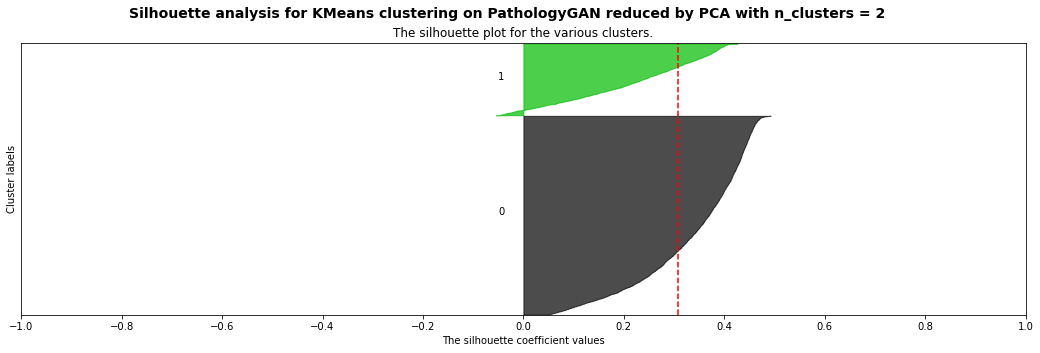

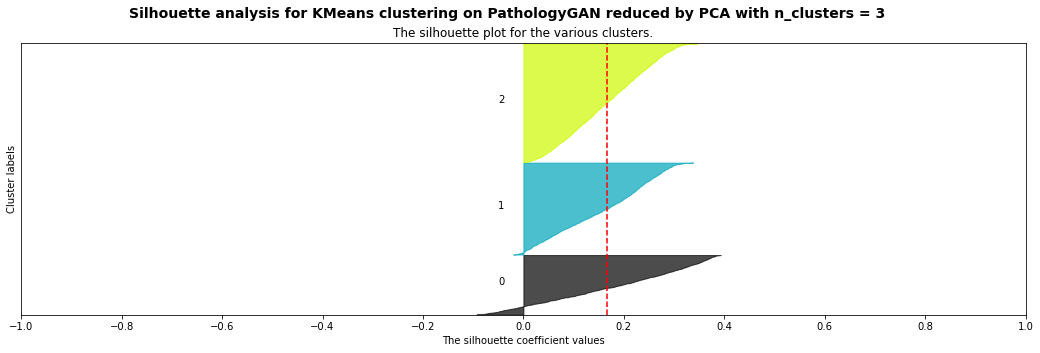

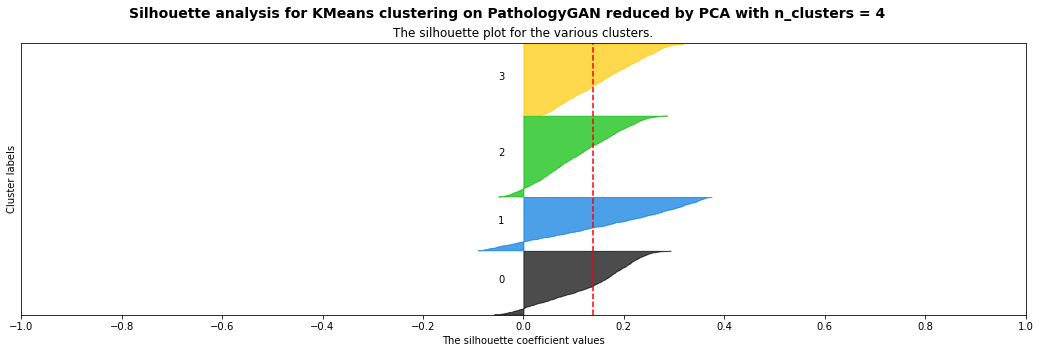

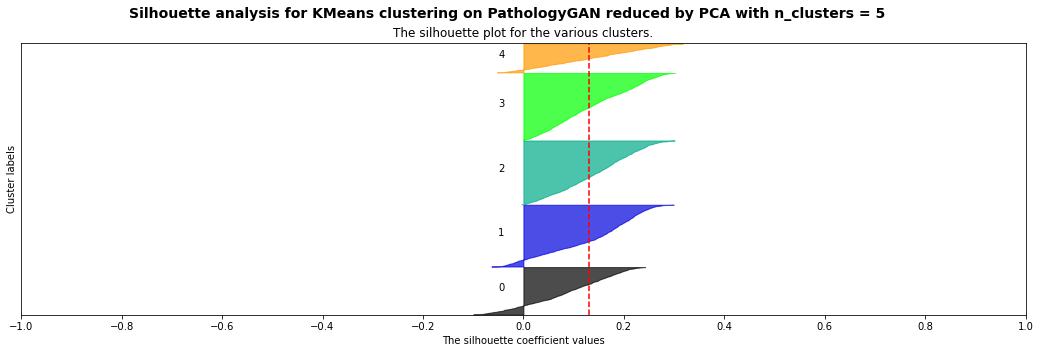

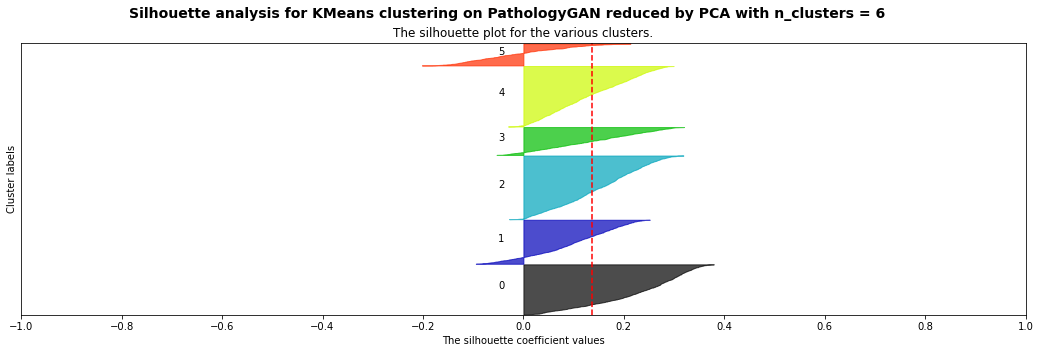

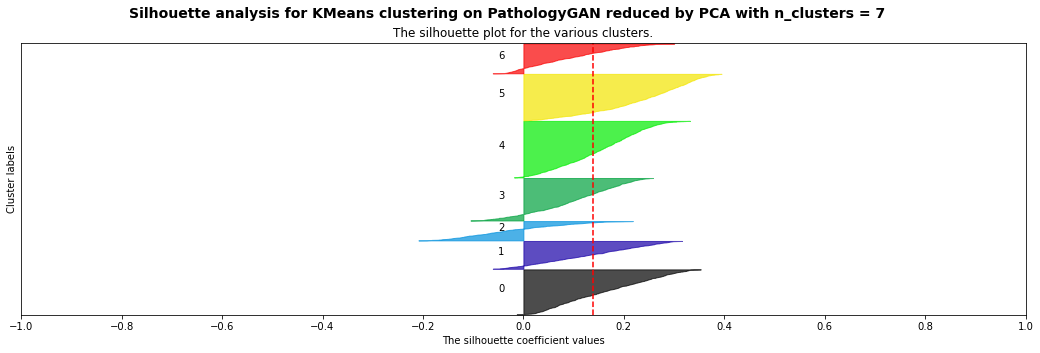

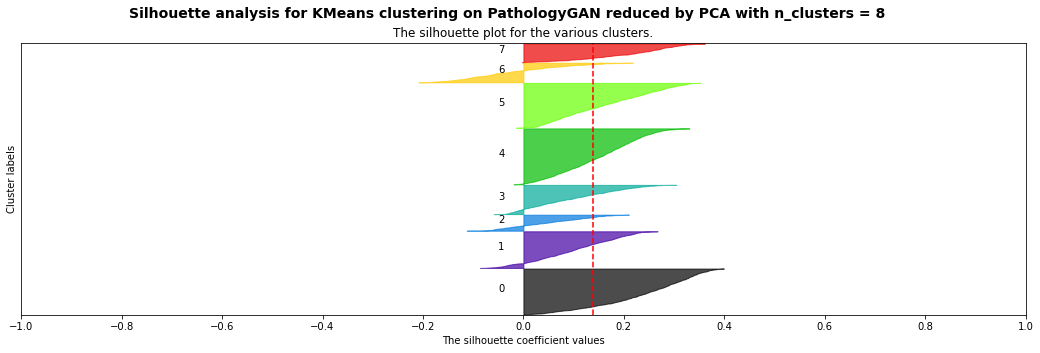

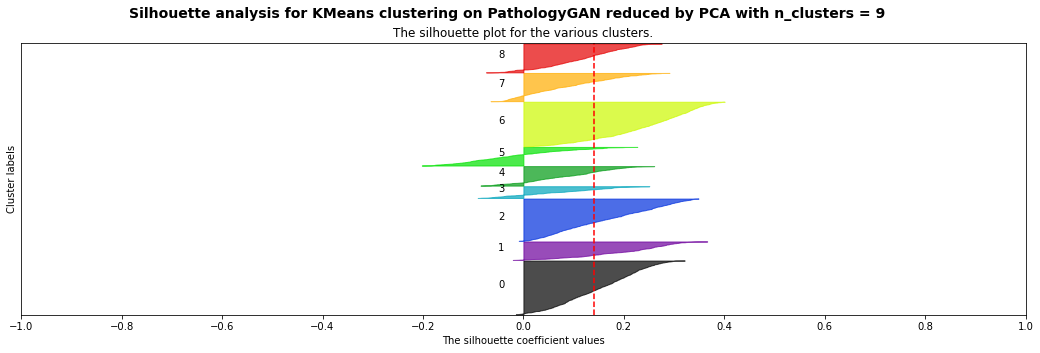

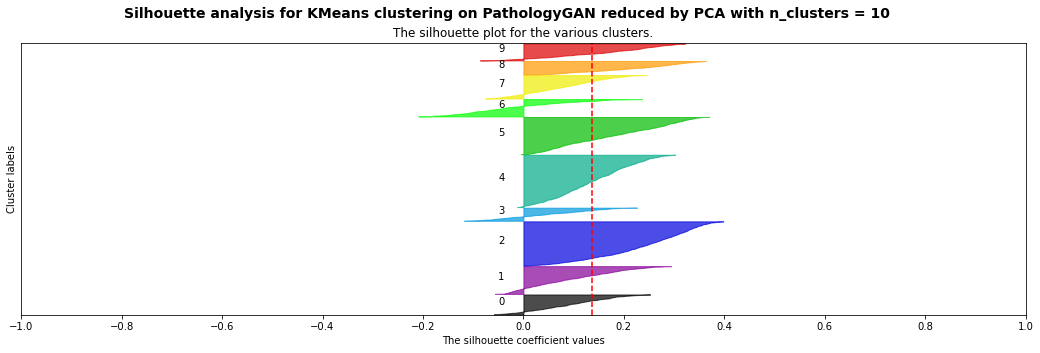

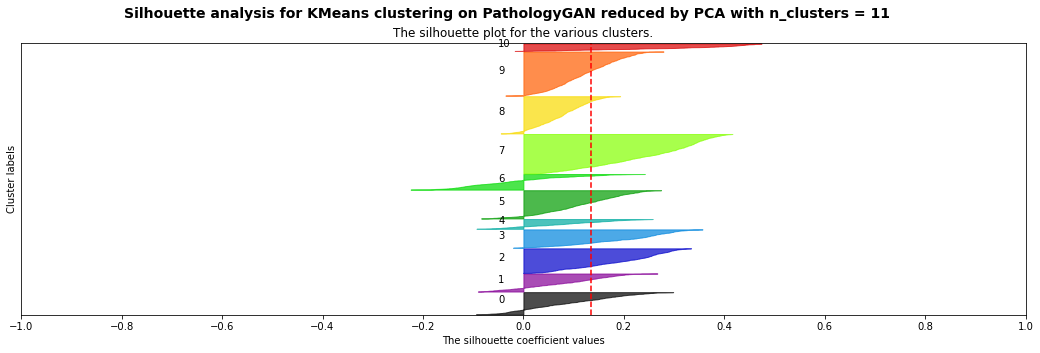

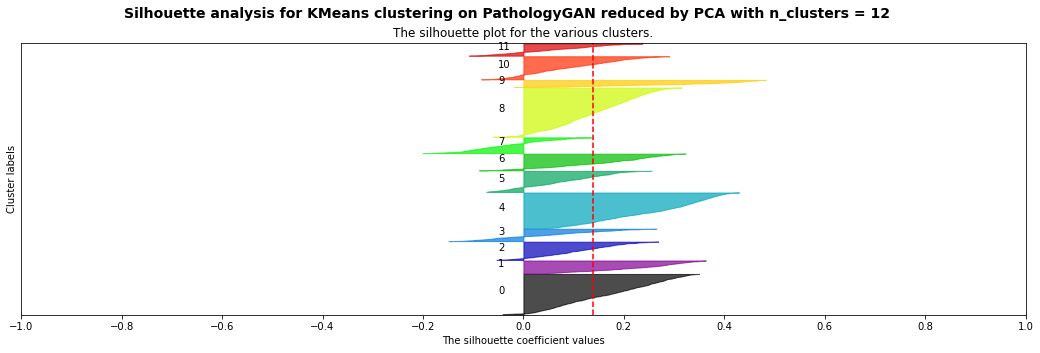

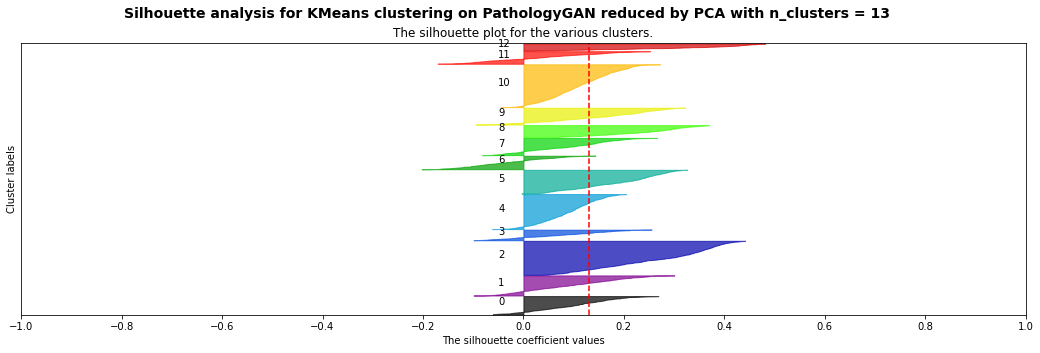

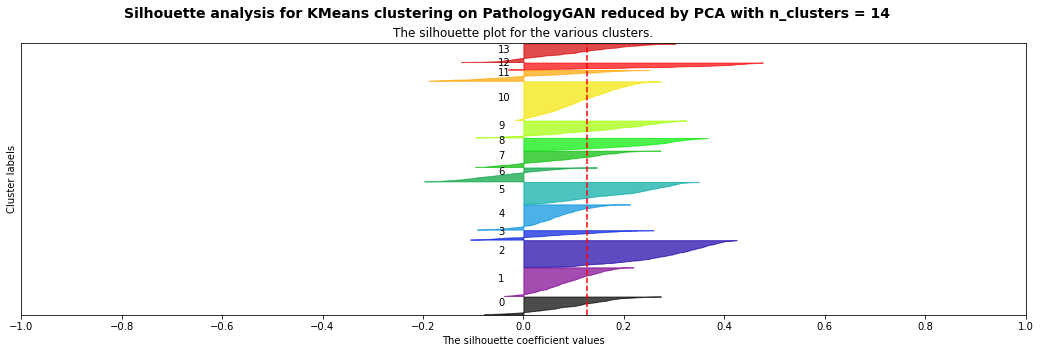

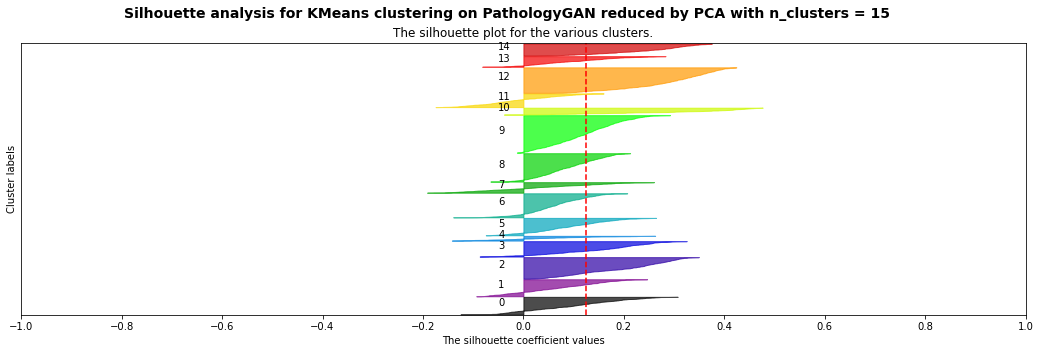

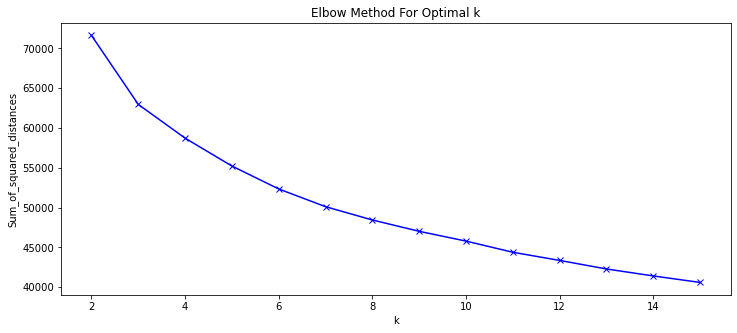

In [15]:
# Selection of Feature set and range of number of clusters 
X = pge_pca_feature
cluster_range = range(2,16)

#List to store inertia values to visualize elbow method plot
pge_pca_elbow =[]

for n_clusters in cluster_range:
    # Create a subplot and give appropriate figure size 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    #Model training and fitting
    k_means_pge_pca = KMeans(n_clusters=n_clusters, random_state=10)
    k_means_pge_pca_assignment = k_means_pge_pca.fit_predict(X)
    k_means_pge_pca_assignment_elbow = k_means_pge_pca.fit(X)
    pge_pca_elbow.append(k_means_pge_pca_assignment_elbow.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, k_means_pge_pca_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Computing the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, k_means_pge_pca_assignment)

    y_lower = 10
    for i in range(n_clusters):
        #Selecting the sample values as per the cluster number and sorting
        ith_cluster_silhouette_values = sample_silhouette_values[k_means_pge_pca_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on PathologyGAN reduced by PCA with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.figure(figsize=(12,5))
plt.plot(cluster_range, pge_pca_elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Model Type 2: K-means model using PathologyGAN feature set reduced by UMAP

For clusters = 2 avg silhouette_score = 0.41184482
For clusters = 3 avg silhouette_score = 0.48857954
For clusters = 4 avg silhouette_score = 0.5153348
For clusters = 5 avg silhouette_score = 0.55319804
For clusters = 6 avg silhouette_score = 0.5880003
For clusters = 7 avg silhouette_score = 0.6156872
For clusters = 8 avg silhouette_score = 0.5452252
For clusters = 9 avg silhouette_score = 0.5309919
For clusters = 10 avg silhouette_score = 0.5295836
For clusters = 11 avg silhouette_score = 0.55015314
For clusters = 12 avg silhouette_score = 0.56265163
For clusters = 13 avg silhouette_score = 0.5676042
For clusters = 14 avg silhouette_score = 0.55393255
For clusters = 15 avg silhouette_score = 0.5448034


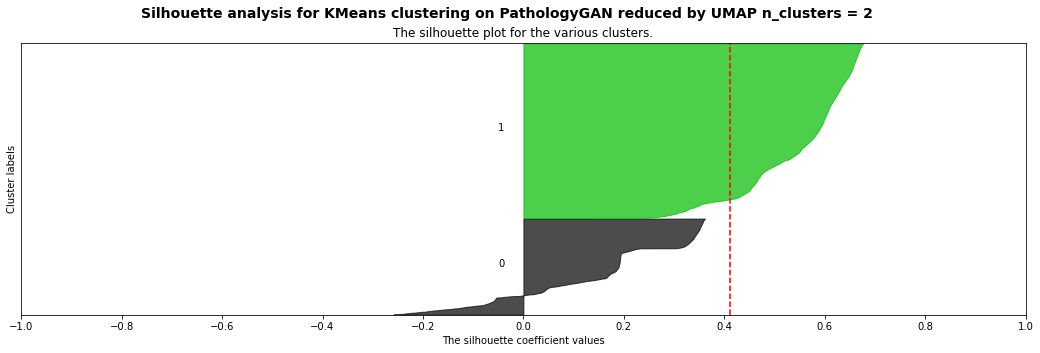

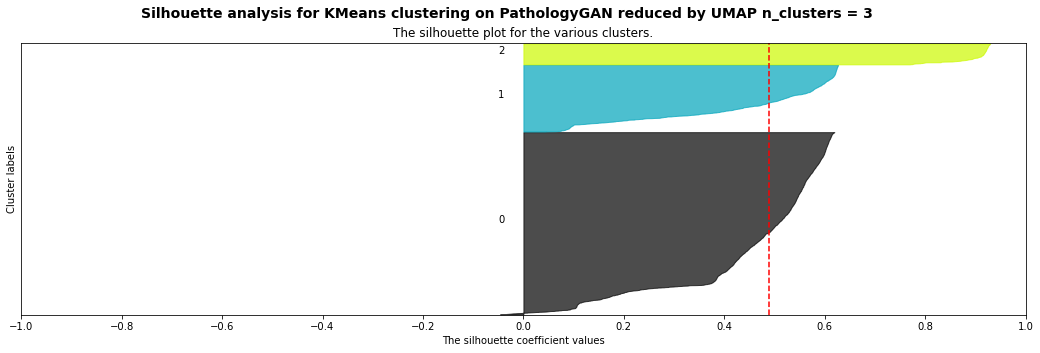

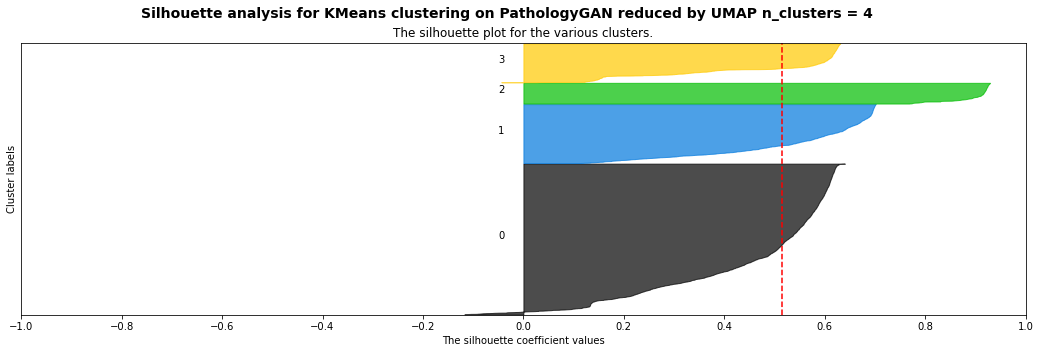

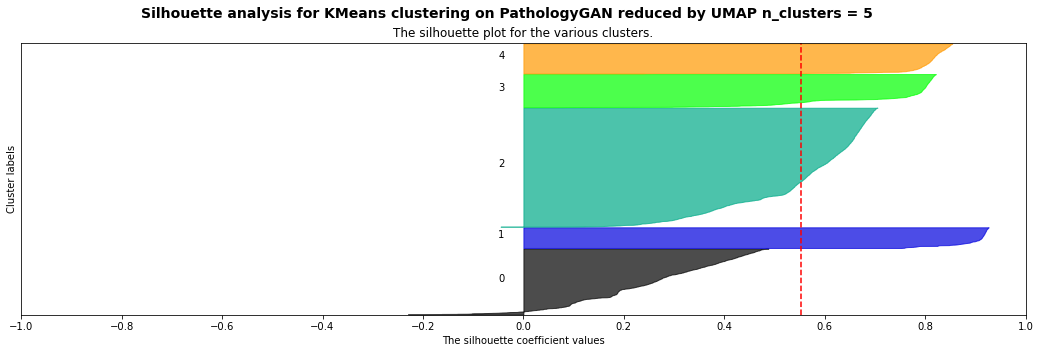

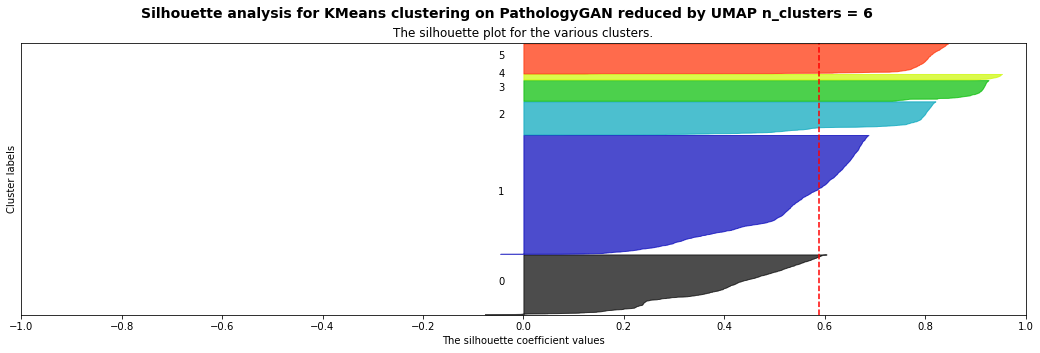

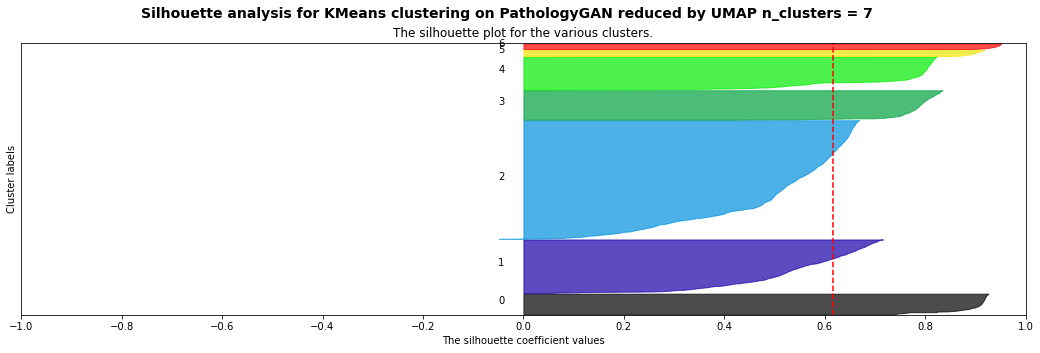

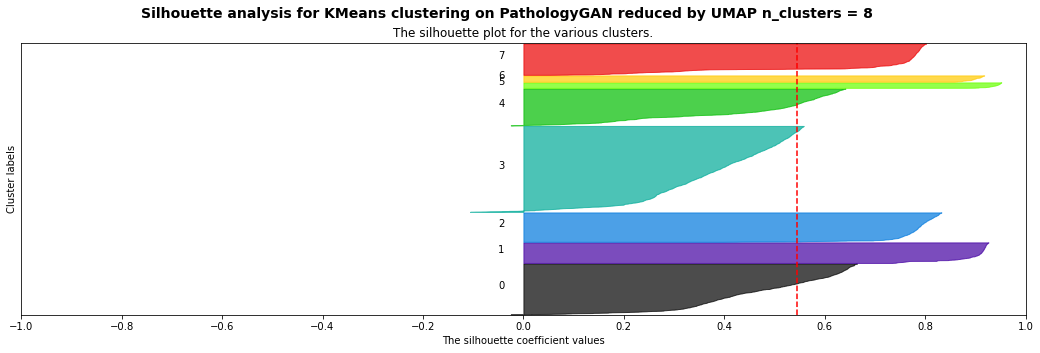

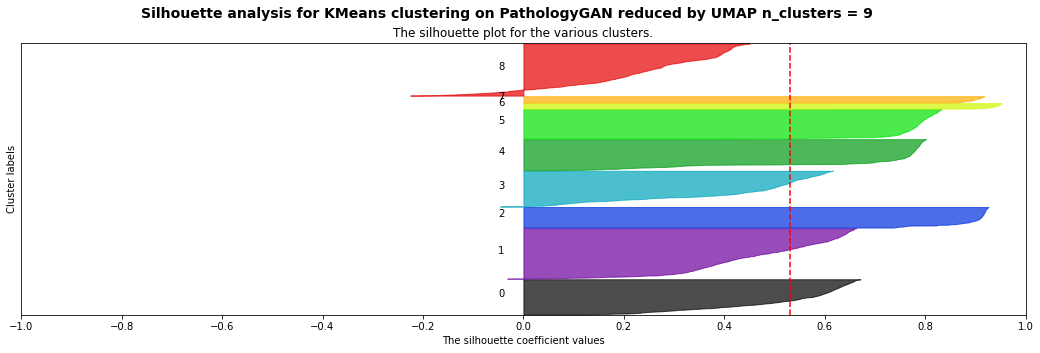

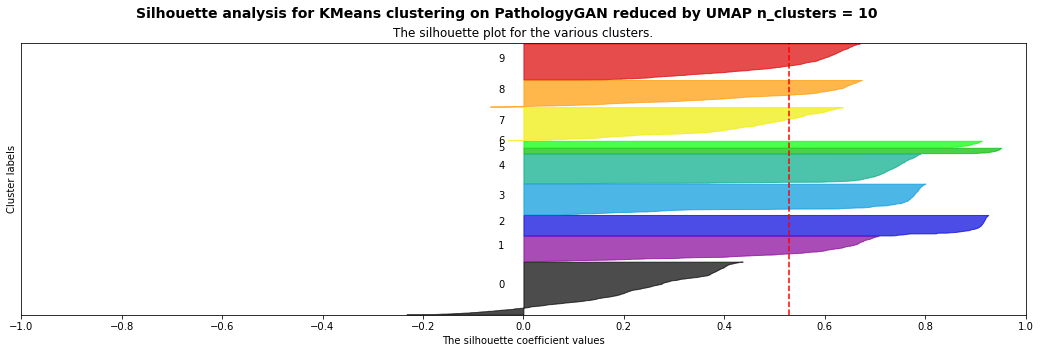

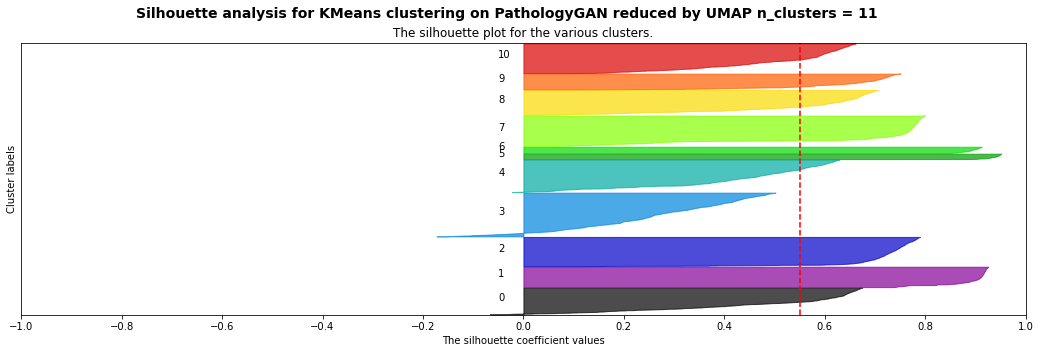

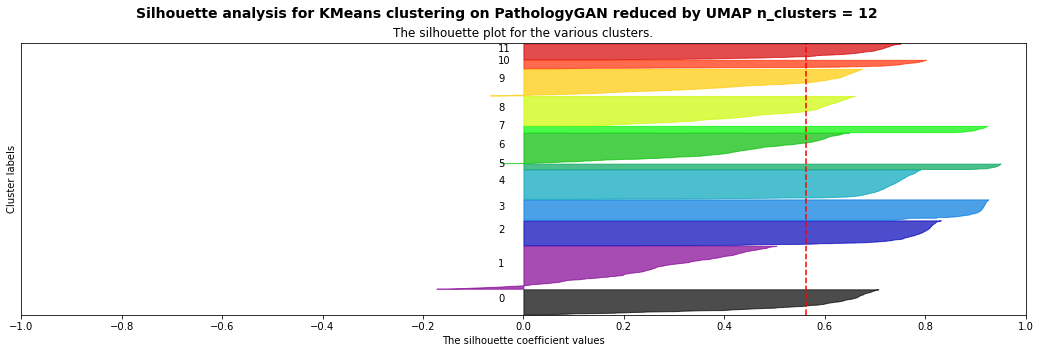

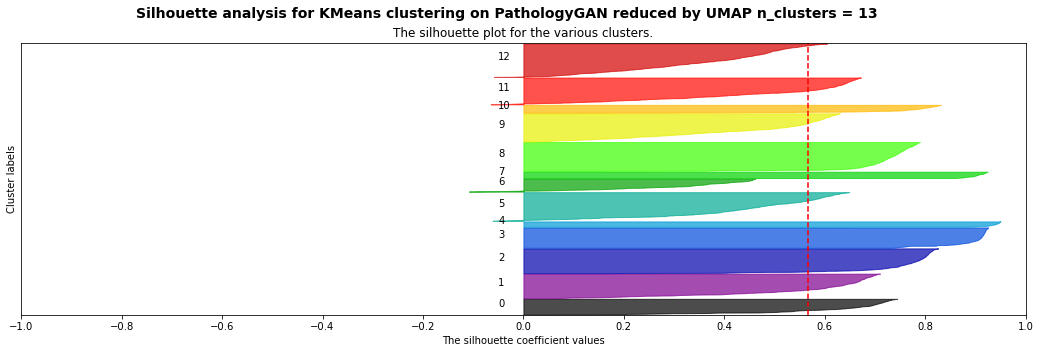

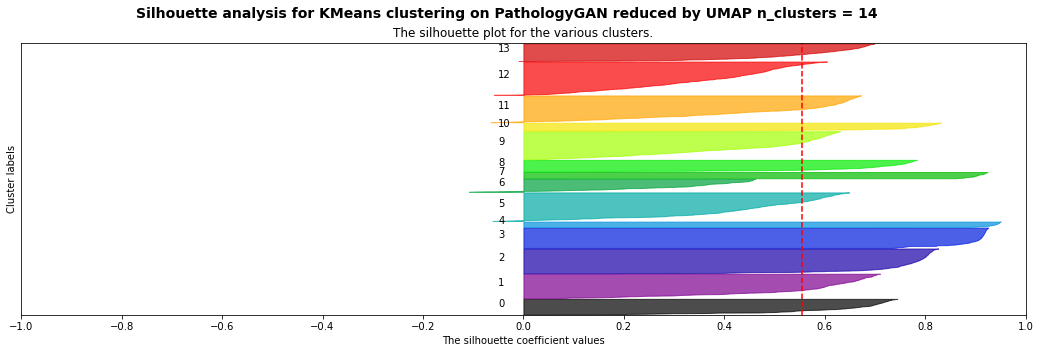

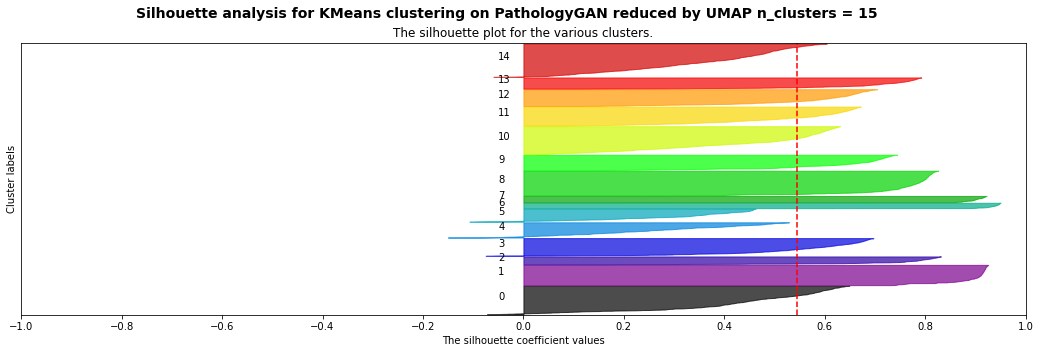

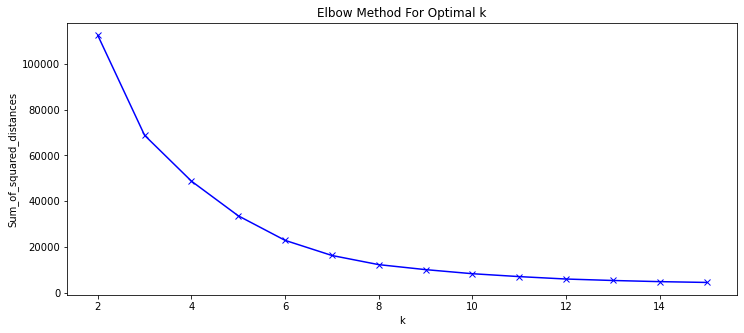

In [16]:
# Selection of Feature set and range of number of clusters 
X = pge_umap_feature
cluster_range = range(2,16)

#List to store inertia values to visualize elbow method plot
pge_umap_elbow =[]

for n_clusters in cluster_range:
    # Create a subplot and give appropriate figure size
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #Model training and fitting
    k_means_pge_umap = KMeans(n_clusters=n_clusters, random_state=10)
    k_means_pge_umap_assignment = k_means_pge_umap.fit_predict(X)
    k_means_pge_umap_assignment_elbow = k_means_pge_umap.fit(X)
    pge_umap_elbow.append(k_means_pge_umap_assignment_elbow.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, k_means_pge_umap_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, k_means_pge_umap_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[k_means_pge_umap_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on PathologyGAN reduced by UMAP n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.figure(figsize=(12,5))
plt.plot(cluster_range, pge_umap_elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Model Type 3: K-means model using ResNet50 feature set reduced by PCA

For clusters = 2 avg silhouette_score = 0.13249631
For clusters = 3 avg silhouette_score = 0.14689067
For clusters = 4 avg silhouette_score = 0.16714846
For clusters = 5 avg silhouette_score = 0.15361655
For clusters = 6 avg silhouette_score = 0.15694593
For clusters = 7 avg silhouette_score = 0.15658335
For clusters = 8 avg silhouette_score = 0.15991552
For clusters = 9 avg silhouette_score = 0.15885374
For clusters = 10 avg silhouette_score = 0.14938381
For clusters = 11 avg silhouette_score = 0.14883848
For clusters = 12 avg silhouette_score = 0.14739944
For clusters = 13 avg silhouette_score = 0.14251973
For clusters = 14 avg silhouette_score = 0.1424954
For clusters = 15 avg silhouette_score = 0.13745147


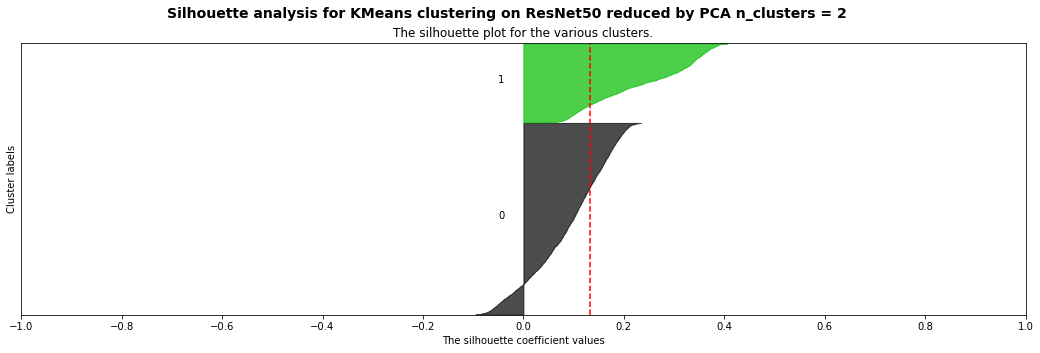

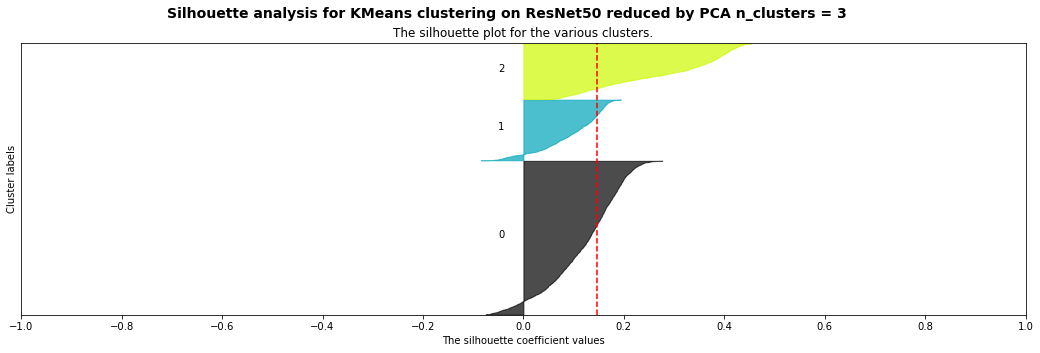

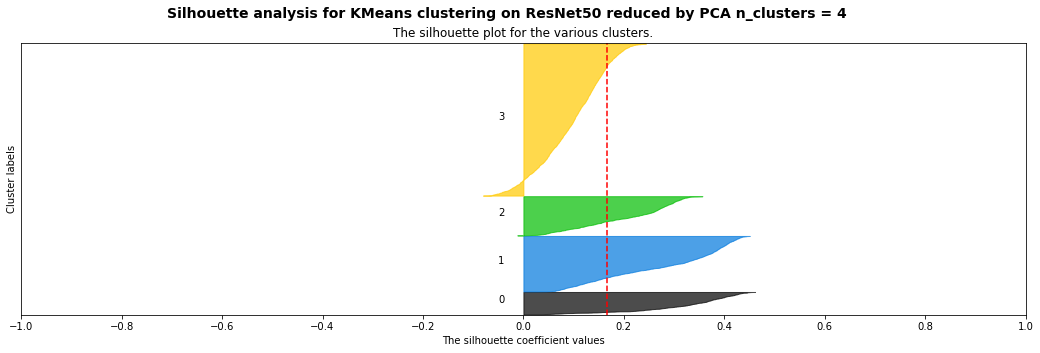

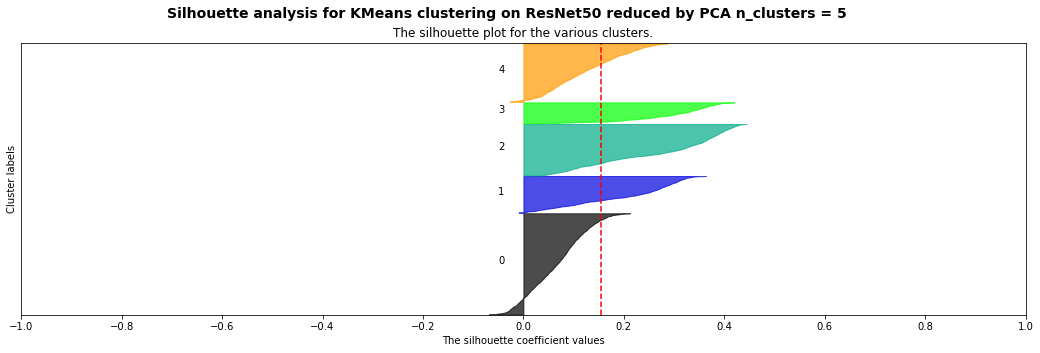

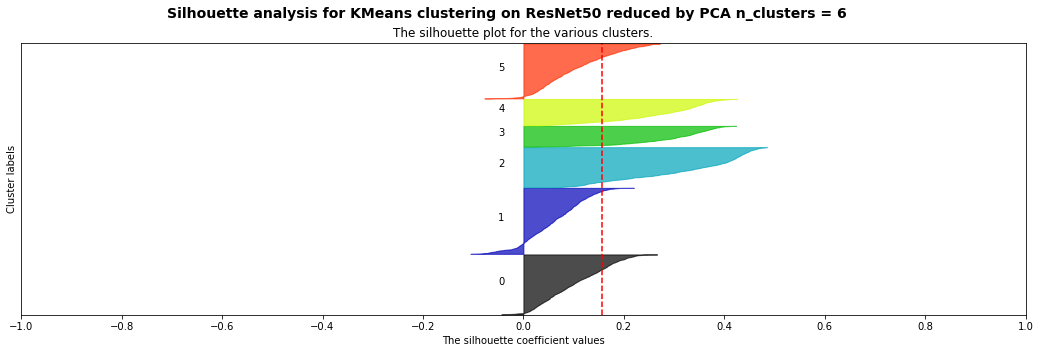

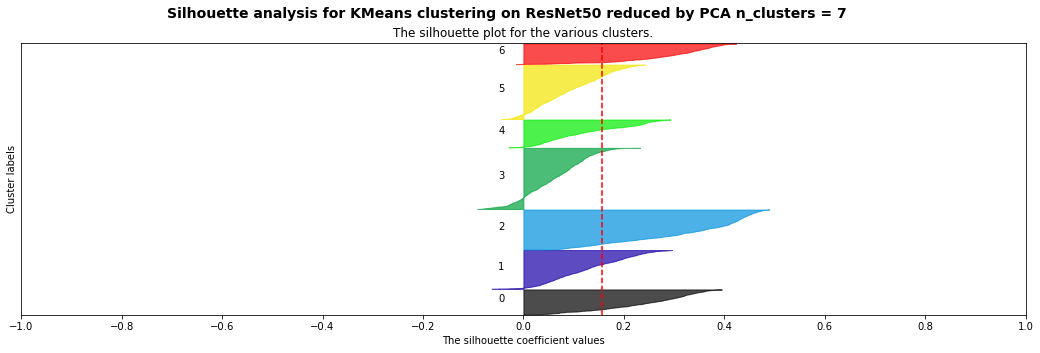

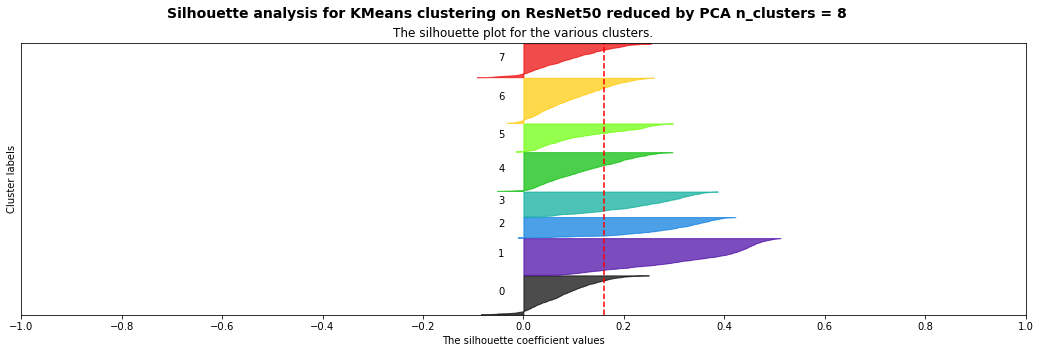

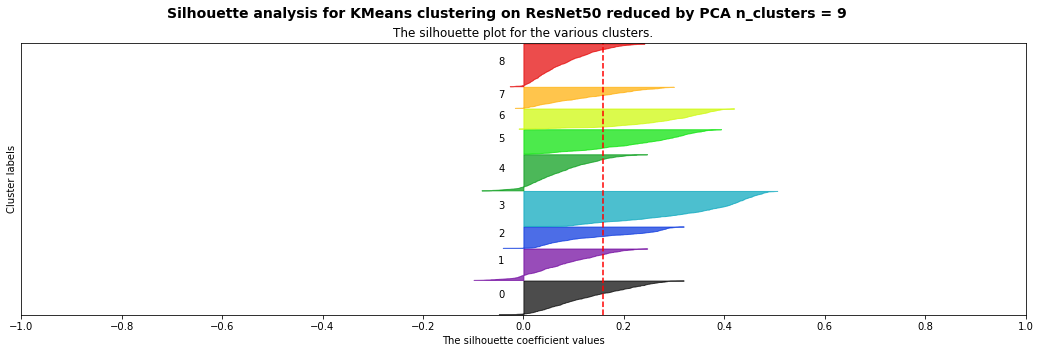

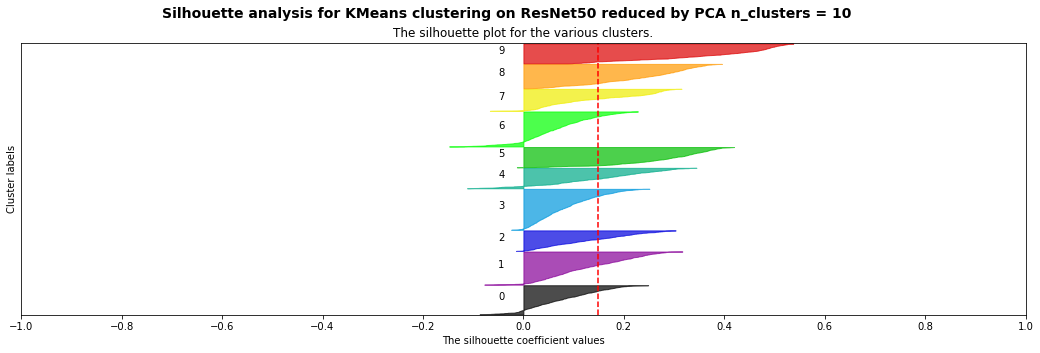

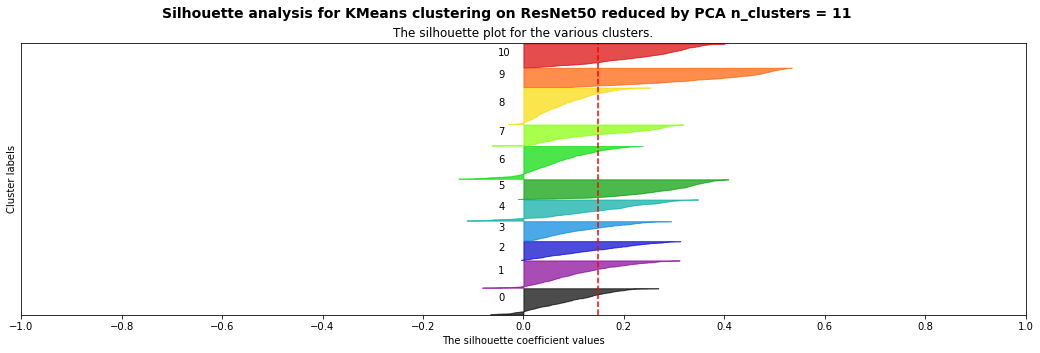

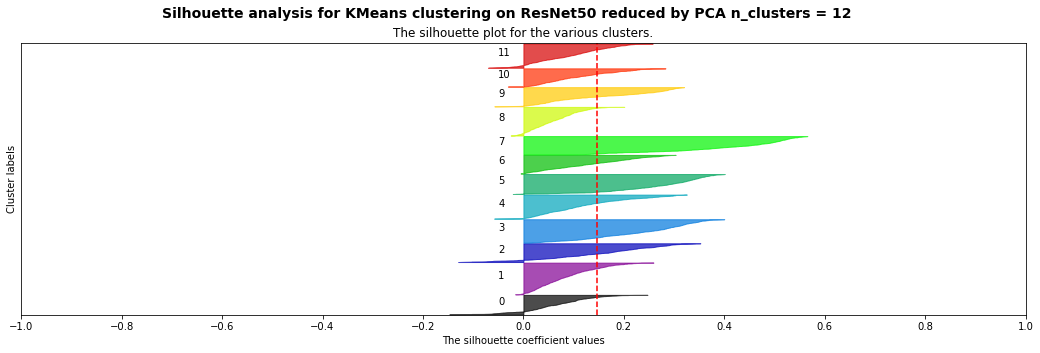

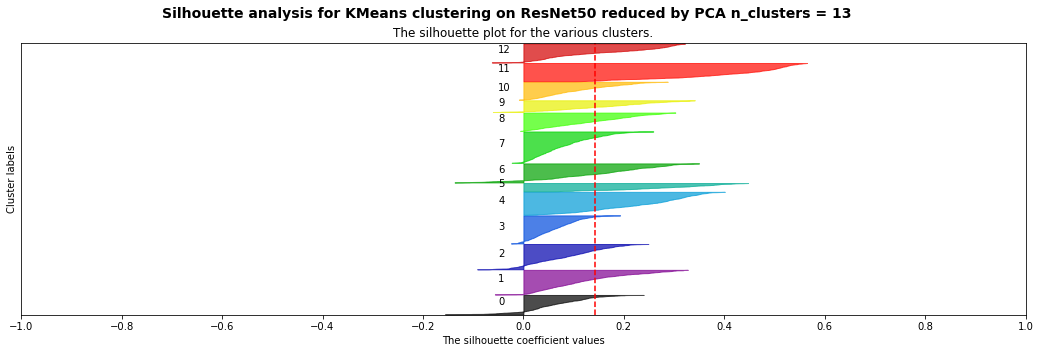

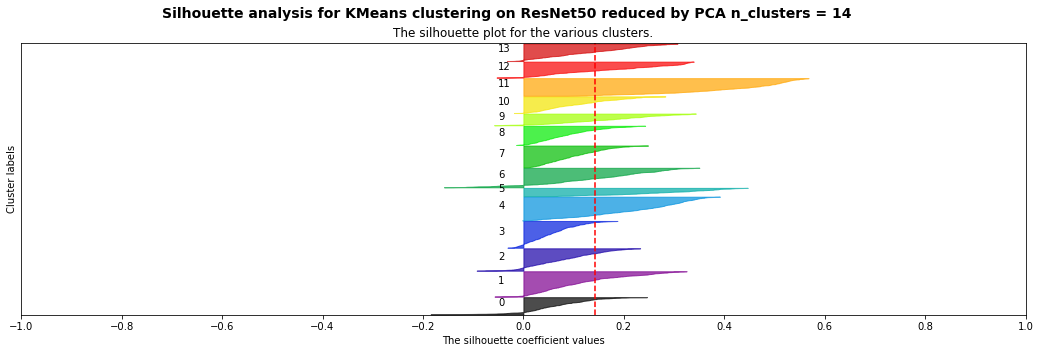

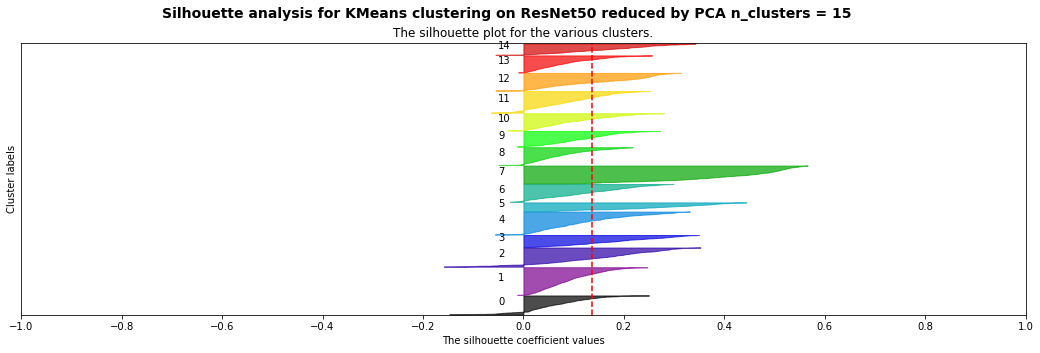

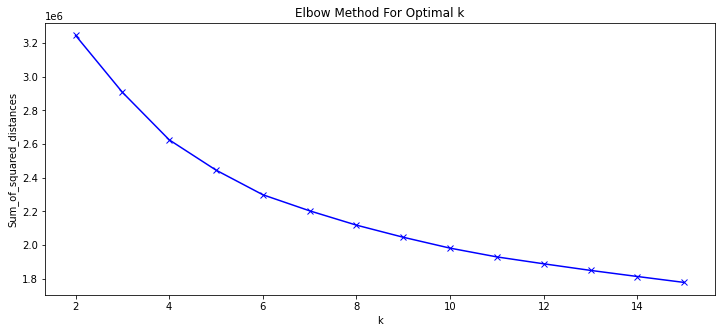

In [17]:
X = resnet50_pca_feature
cluster_range = range(2,16)

resnet50_pca_elbow =[]

for n_clusters in cluster_range:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot and can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    k_means_resnet50_pca = KMeans(n_clusters=n_clusters, random_state=10)
    k_means_resnet50_pca_assignment = k_means_resnet50_pca.fit_predict(X)
    k_means_resnet50_pca_assignment_elbow = k_means_resnet50_pca.fit(X)
    resnet50_pca_elbow.append(k_means_resnet50_pca_assignment_elbow.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, k_means_resnet50_pca_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, k_means_resnet50_pca_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[k_means_resnet50_pca_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on ResNet50 reduced by PCA n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.figure(figsize=(12,5))
plt.plot(cluster_range, resnet50_pca_elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Model Type 4: K-means model using ResNet50 feature set reduced by UMAP

For clusters = 2 avg silhouette_score = 0.4951295
For clusters = 3 avg silhouette_score = 0.5143266
For clusters = 4 avg silhouette_score = 0.5827701
For clusters = 5 avg silhouette_score = 0.4429553
For clusters = 6 avg silhouette_score = 0.479389
For clusters = 7 avg silhouette_score = 0.5148252
For clusters = 8 avg silhouette_score = 0.5162854
For clusters = 9 avg silhouette_score = 0.53705555
For clusters = 10 avg silhouette_score = 0.5288296
For clusters = 11 avg silhouette_score = 0.54727364
For clusters = 12 avg silhouette_score = 0.52086514
For clusters = 13 avg silhouette_score = 0.5363474
For clusters = 14 avg silhouette_score = 0.5539661
For clusters = 15 avg silhouette_score = 0.5849013


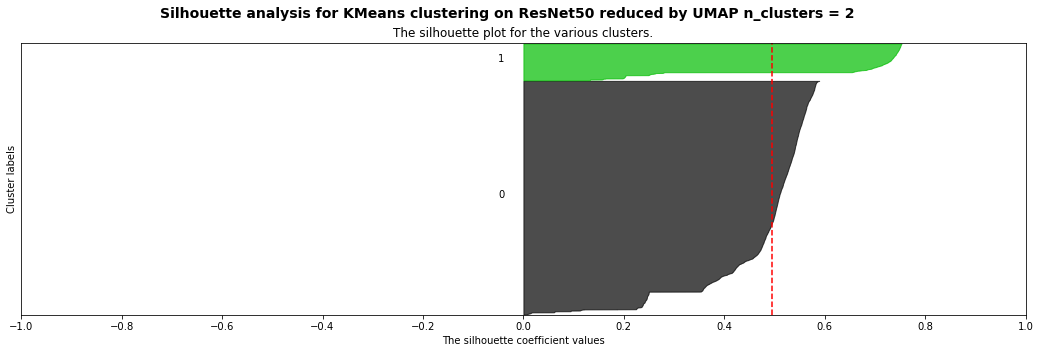

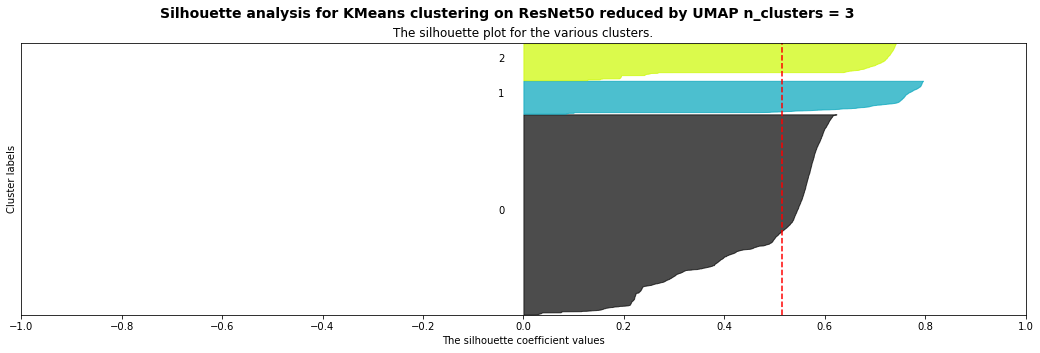

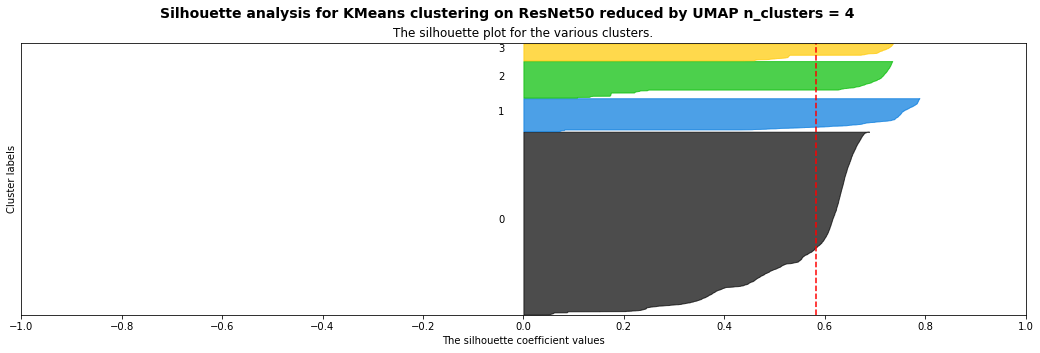

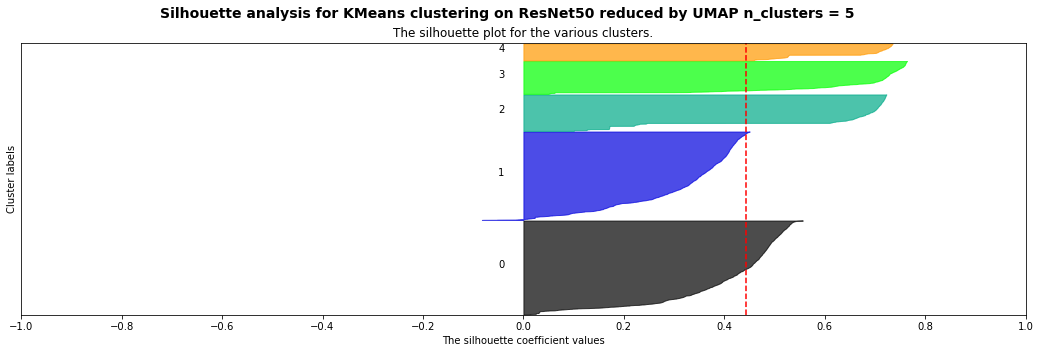

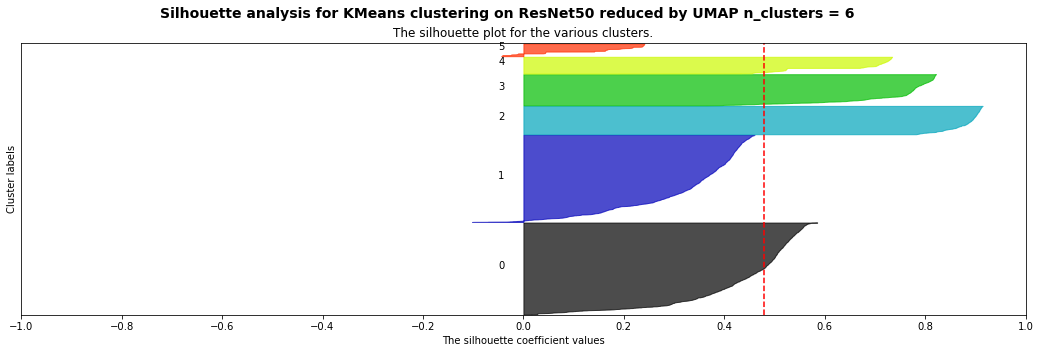

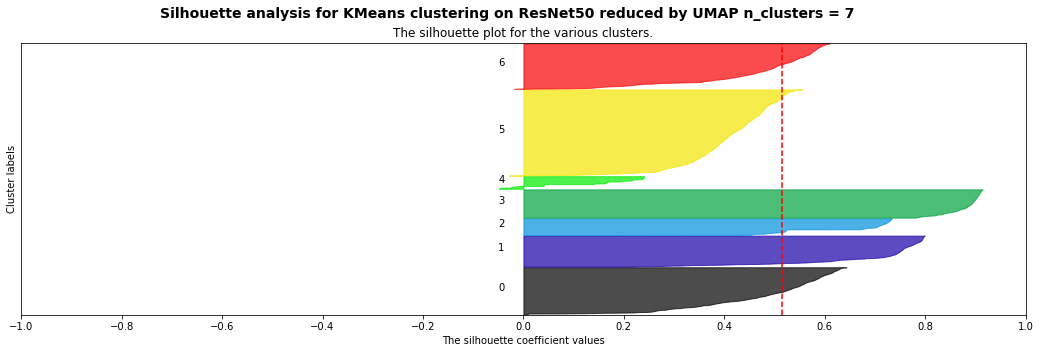

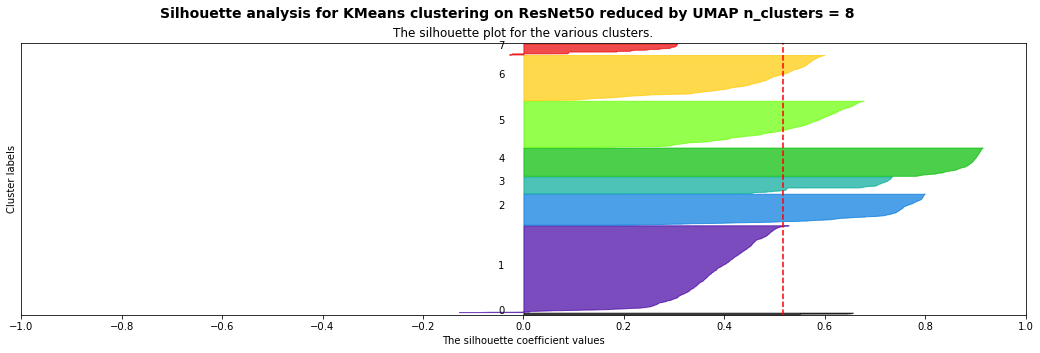

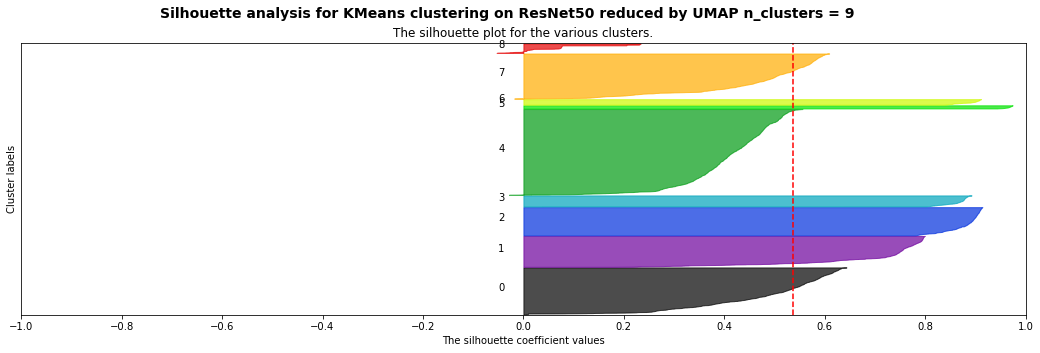

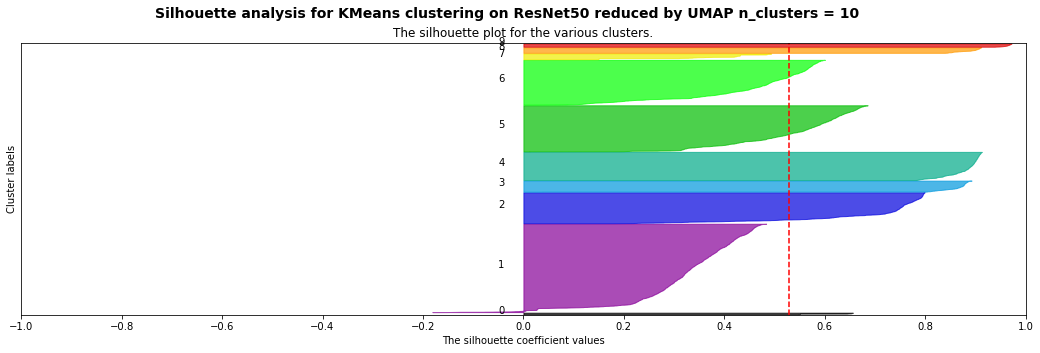

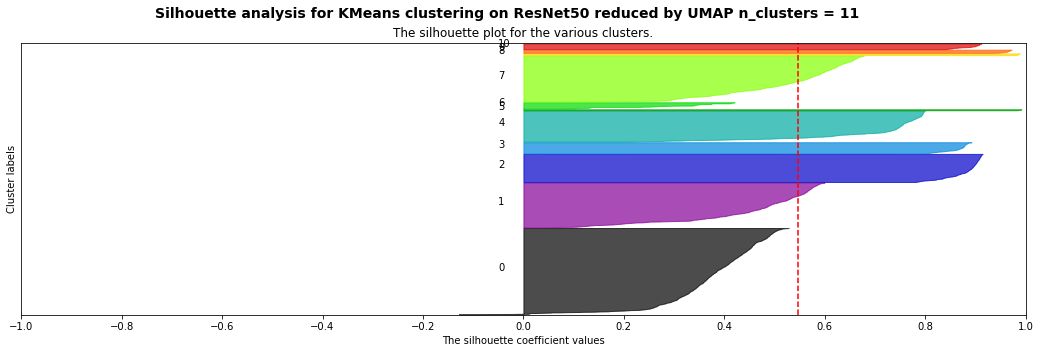

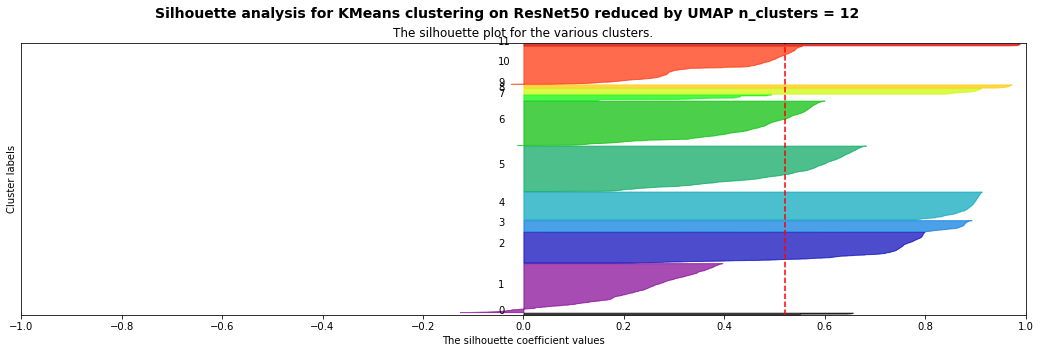

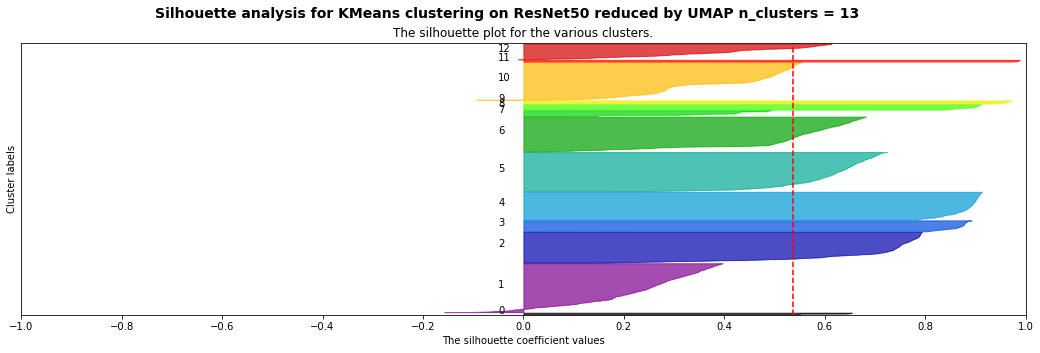

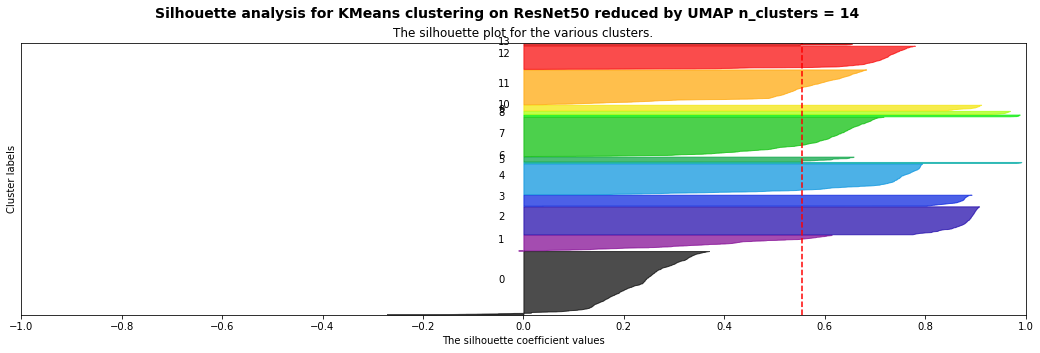

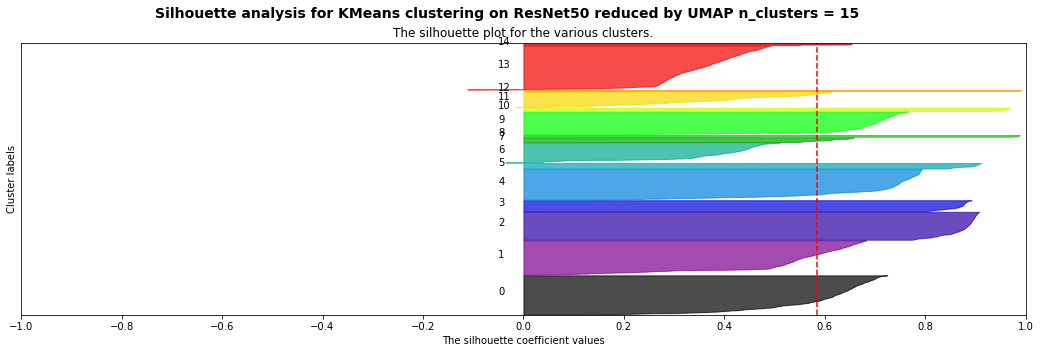

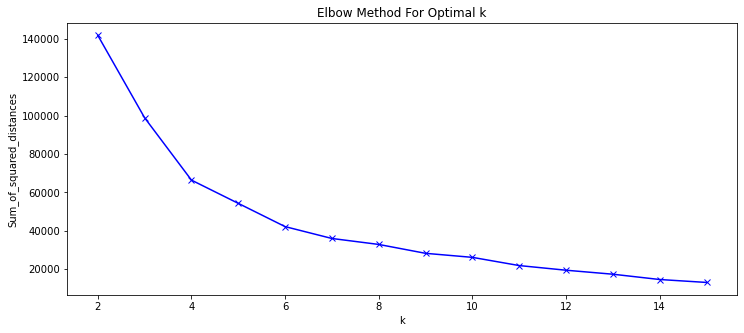

In [18]:
X = resnet50_umap_feature
cluster_range = range(2,16)

resnet50_umap_elbow =[]

for n_clusters in cluster_range:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot and can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    k_means_resnet50_umap = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_resnet50_umap_assignment = k_means_resnet50_umap.fit_predict(X)
    k_means_resnet50_umap_assignment_elbow = k_means_resnet50_umap.fit(X)
    resnet50_umap_elbow.append(k_means_resnet50_umap_assignment_elbow.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, k_means_resnet50_umap_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, k_means_resnet50_umap_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[k_means_resnet50_umap_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on ResNet50 reduced by UMAP n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.figure(figsize=(12,5))
plt.plot(cluster_range, resnet50_umap_elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


Model Type 5: Hierarchical model using PathologyGAN feature set reduced by PCA

For clusters = 2 avg silhouette_score = 0.3199981
For clusters = 3 avg silhouette_score = 0.13768801
For clusters = 4 avg silhouette_score = 0.09647706
For clusters = 5 avg silhouette_score = 0.07965838
For clusters = 6 avg silhouette_score = 0.09555022
For clusters = 7 avg silhouette_score = 0.09987627
For clusters = 8 avg silhouette_score = 0.10477754
For clusters = 9 avg silhouette_score = 0.109597094
For clusters = 10 avg silhouette_score = 0.104136094
For clusters = 11 avg silhouette_score = 0.10844796
For clusters = 12 avg silhouette_score = 0.105015285
For clusters = 13 avg silhouette_score = 0.09048697
For clusters = 14 avg silhouette_score = 0.091777615
For clusters = 15 avg silhouette_score = 0.09682864


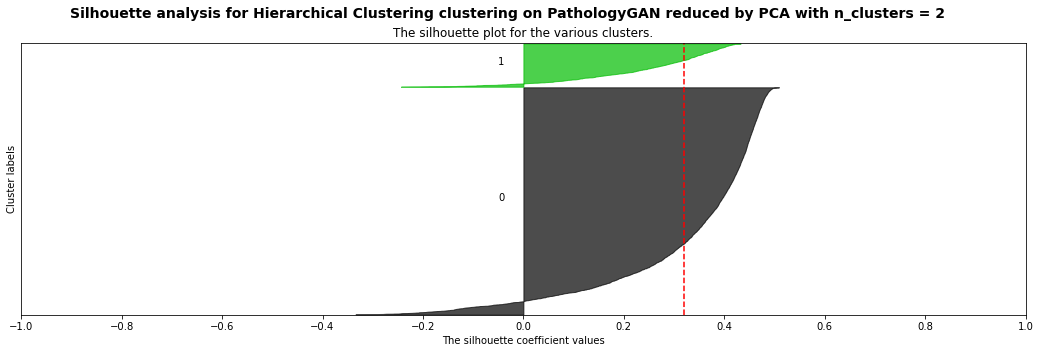

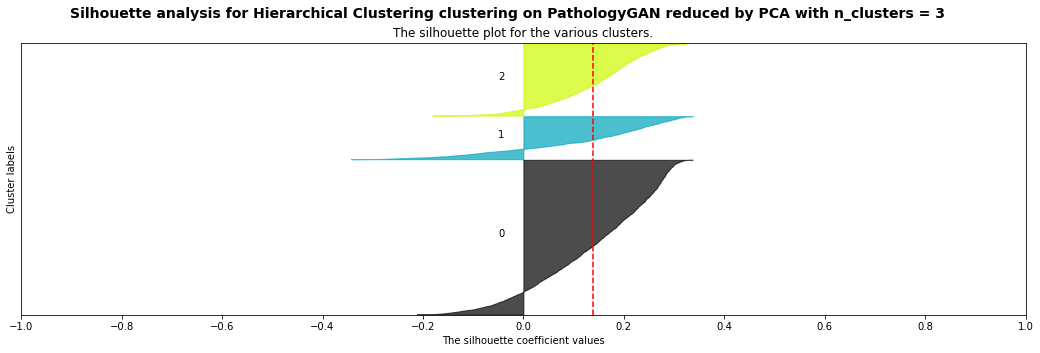

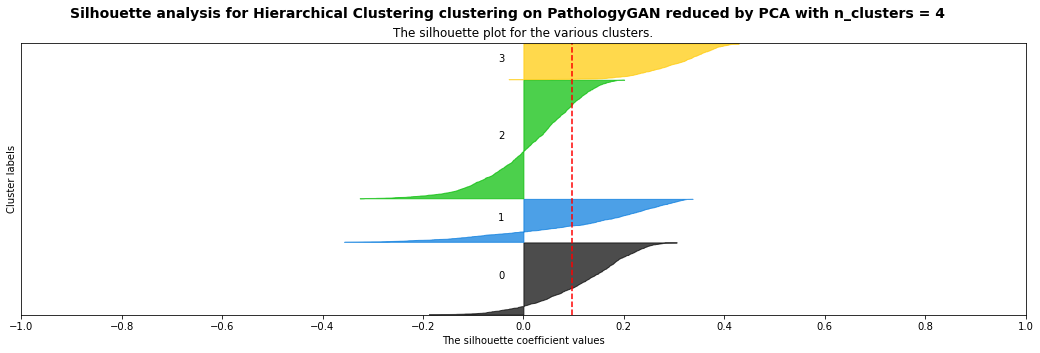

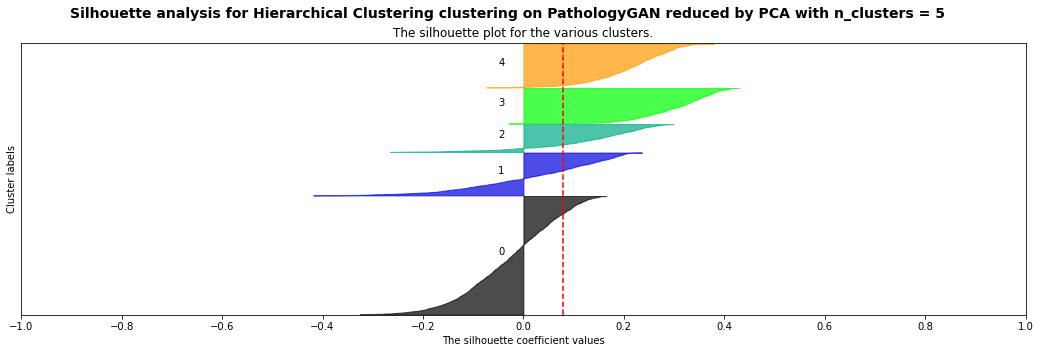

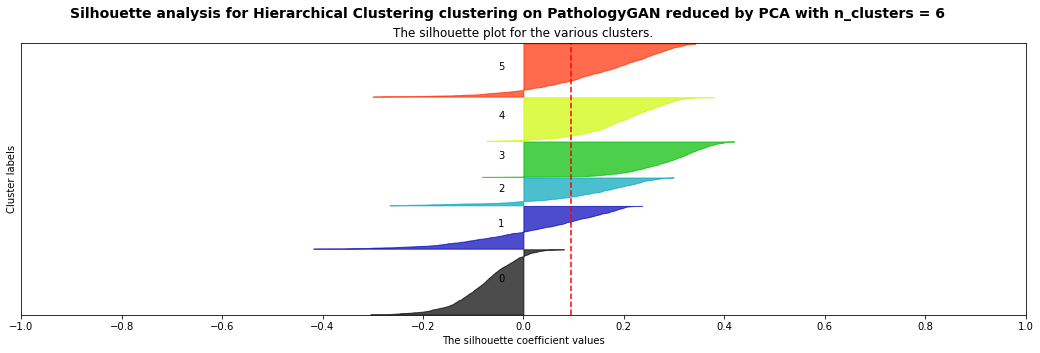

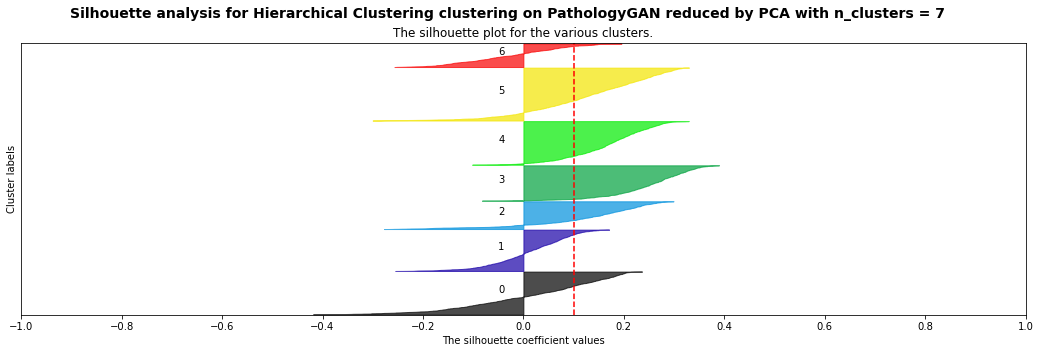

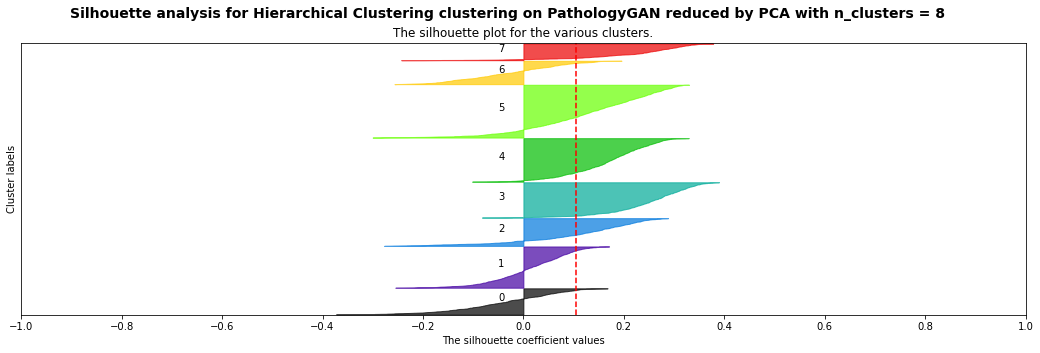

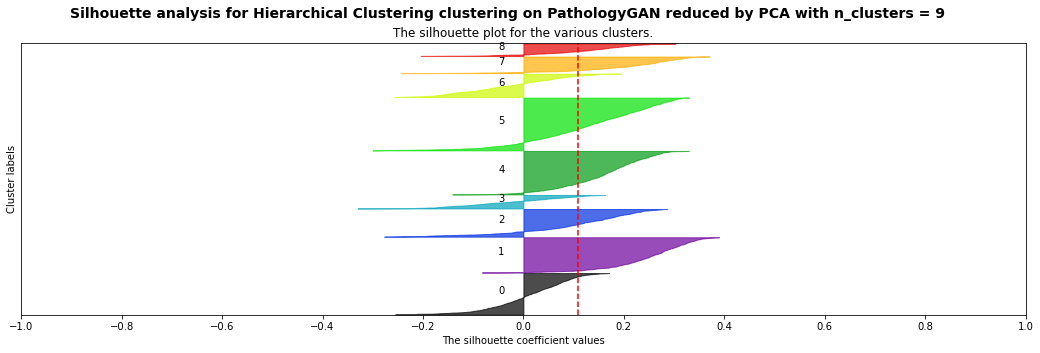

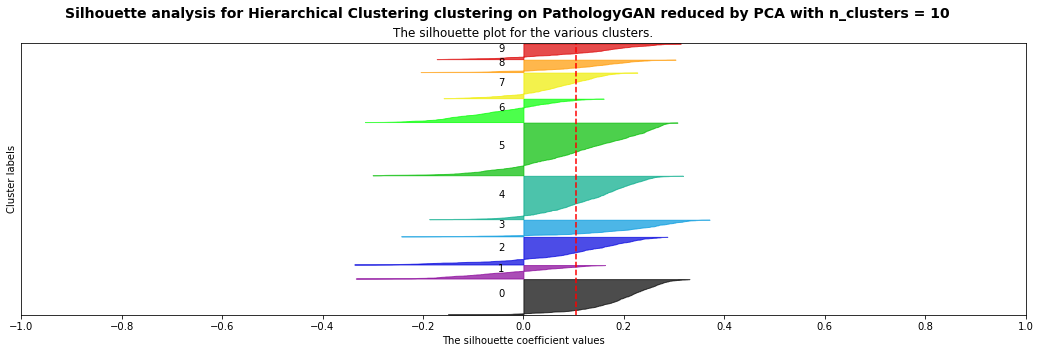

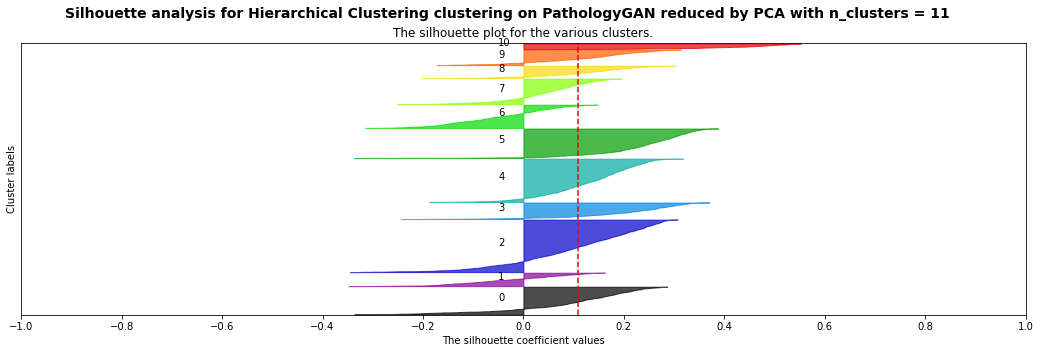

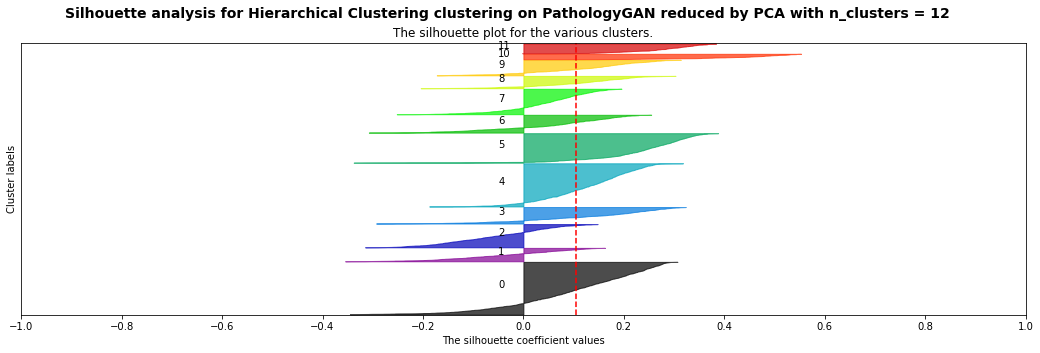

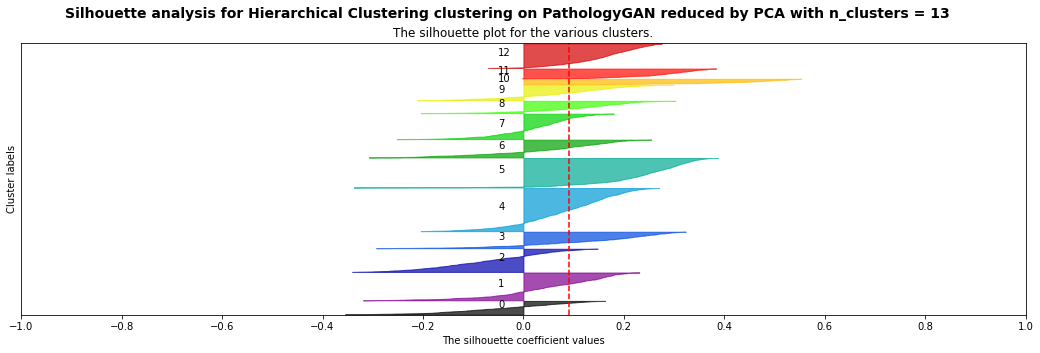

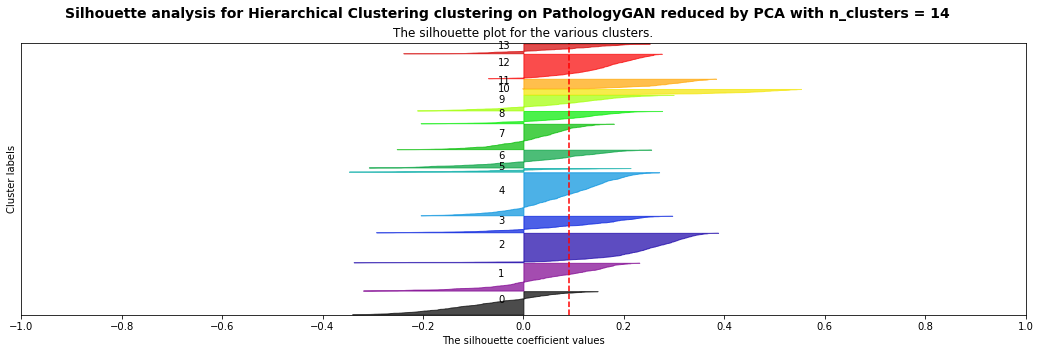

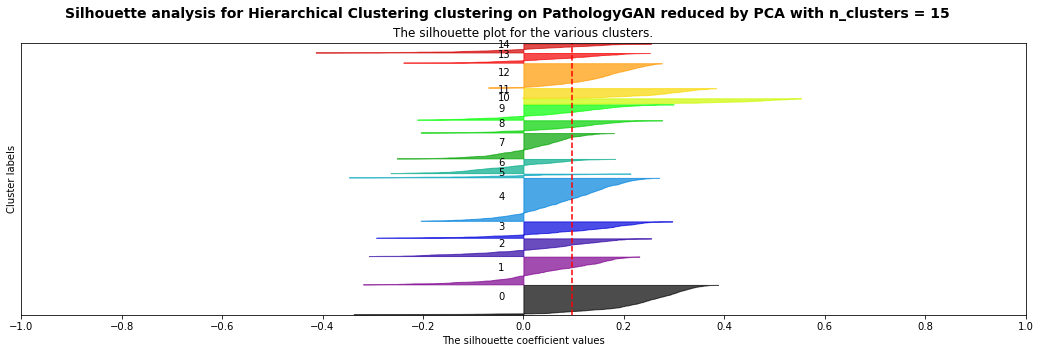

In [23]:
X = pge_pca_feature
cluster_range = range(2,16)

for n_clusters in cluster_range:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot and can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    hier_pge_pca = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean',  linkage='ward') 
    hier_pge_pca_assignment = hier_pge_pca.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, hier_pge_pca_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, hier_pge_pca_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[hier_pge_pca_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for Hierarchical Clustering clustering on PathologyGAN reduced by PCA with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Text(0.5, 1.0, 'Dendrogram for PathologyGAN reduced by PCA')

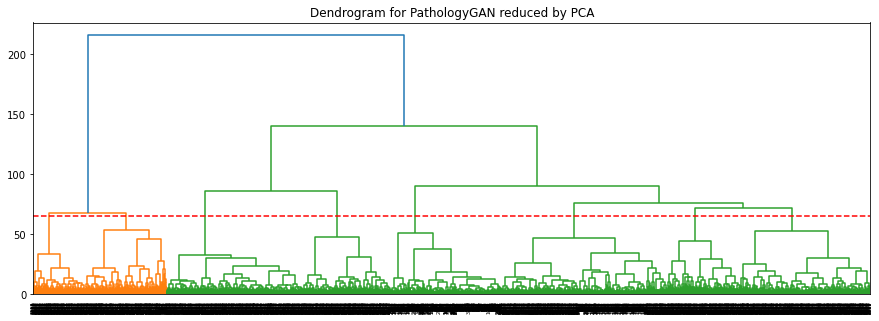

In [241]:
plt.figure(figsize=(15,5))

# Please Uncomment to run and verify dendrogram
#den = sch.dendrogram(sch.linkage(pge_pca_feature, method='ward'))

plt.axhline(y=65, color = 'red', linestyle = '--')
plt.title('Dendrogram for PathologyGAN reduced by PCA')

Model Type 6: Hierarchical model using PathologyGAN feature set reduced by UMAP\

For clusters = 2 avg silhouette_score = 0.38116944
For clusters = 3 avg silhouette_score = 0.46985346
For clusters = 4 avg silhouette_score = 0.5032504
For clusters = 5 avg silhouette_score = 0.5531018
For clusters = 6 avg silhouette_score = 0.58812845
For clusters = 7 avg silhouette_score = 0.61504745
For clusters = 8 avg silhouette_score = 0.5335341
For clusters = 9 avg silhouette_score = 0.5509812
For clusters = 10 avg silhouette_score = 0.53960145
For clusters = 11 avg silhouette_score = 0.5309957
For clusters = 12 avg silhouette_score = 0.54252315
For clusters = 13 avg silhouette_score = 0.5404801
For clusters = 14 avg silhouette_score = 0.52865
For clusters = 15 avg silhouette_score = 0.5227068


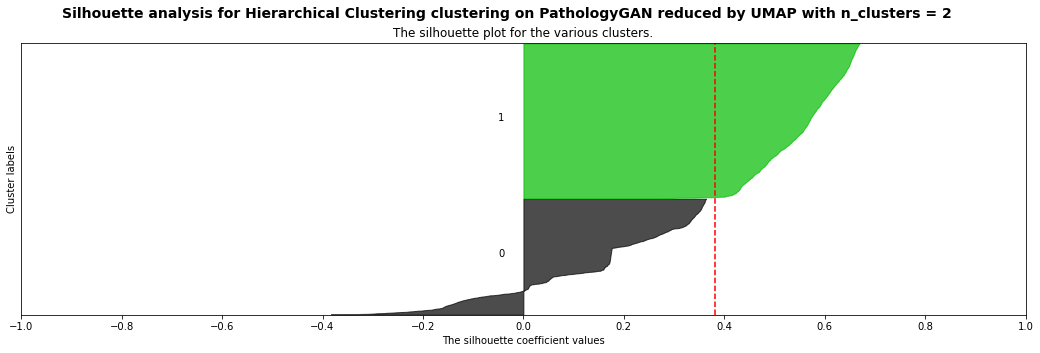

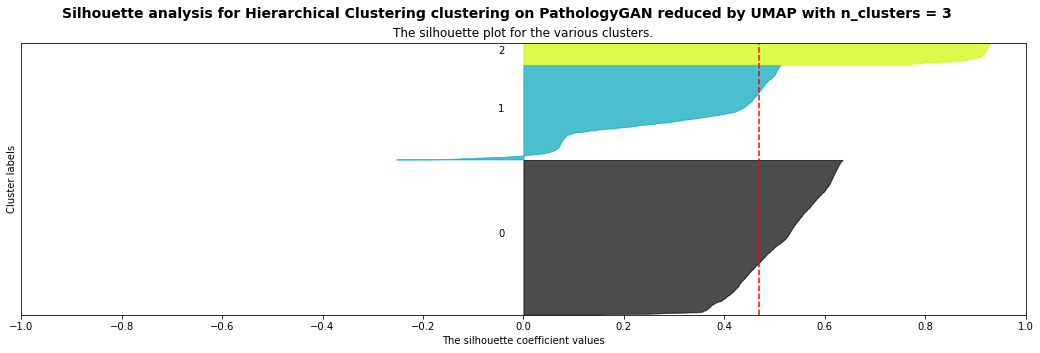

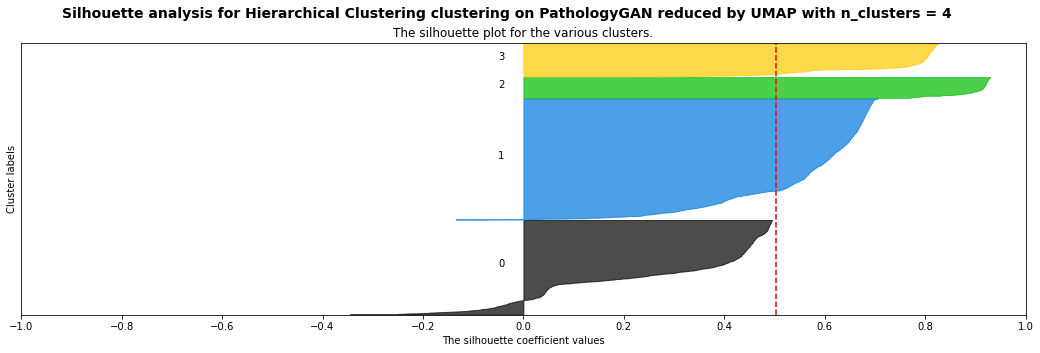

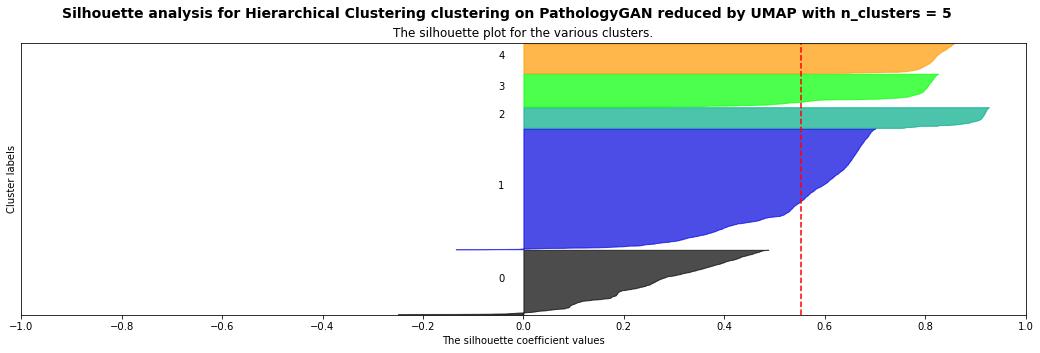

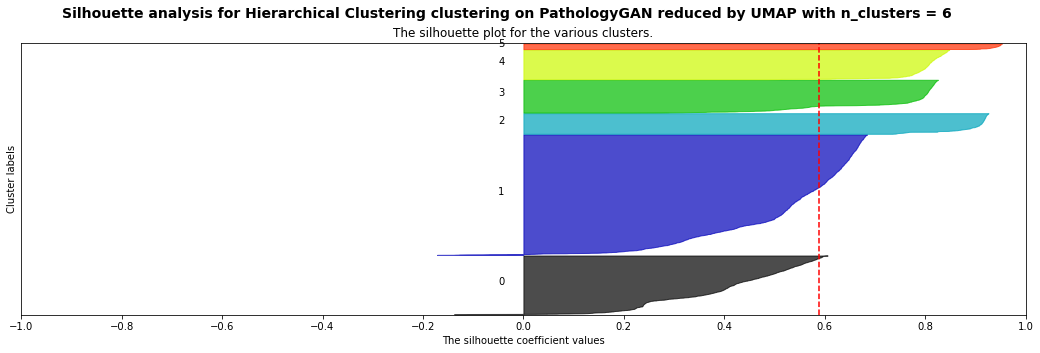

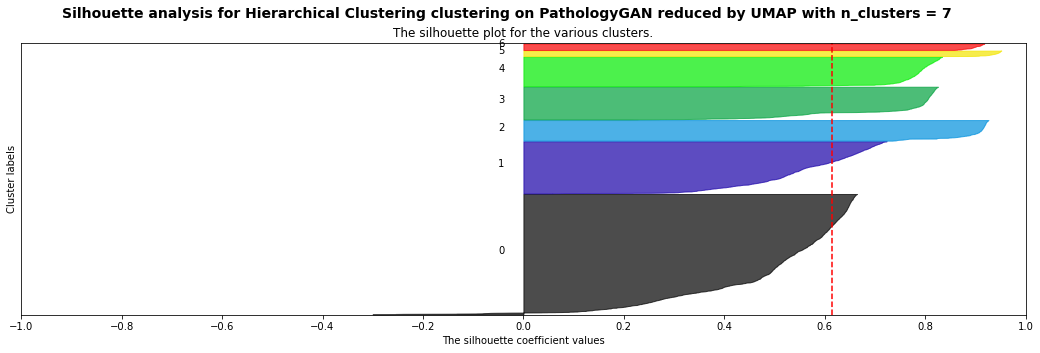

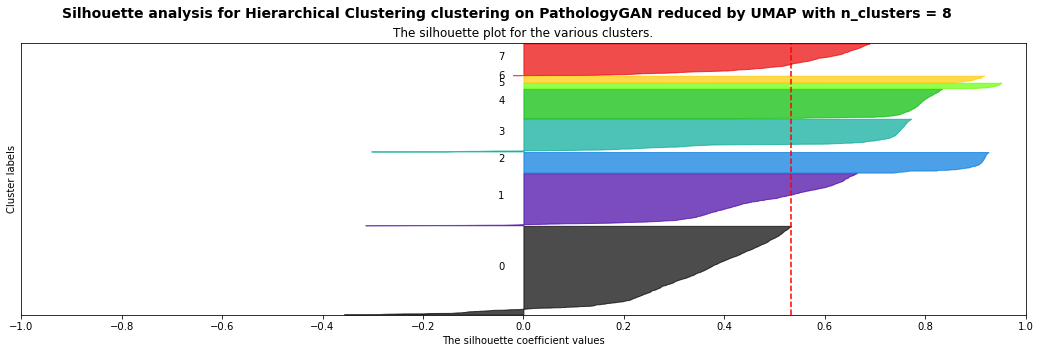

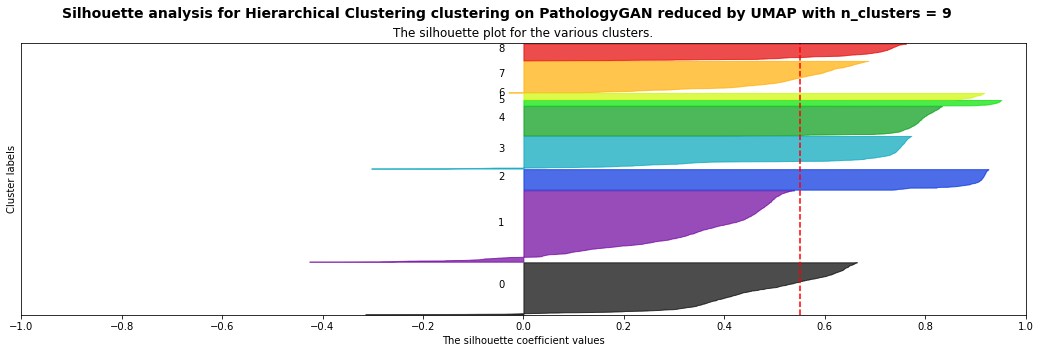

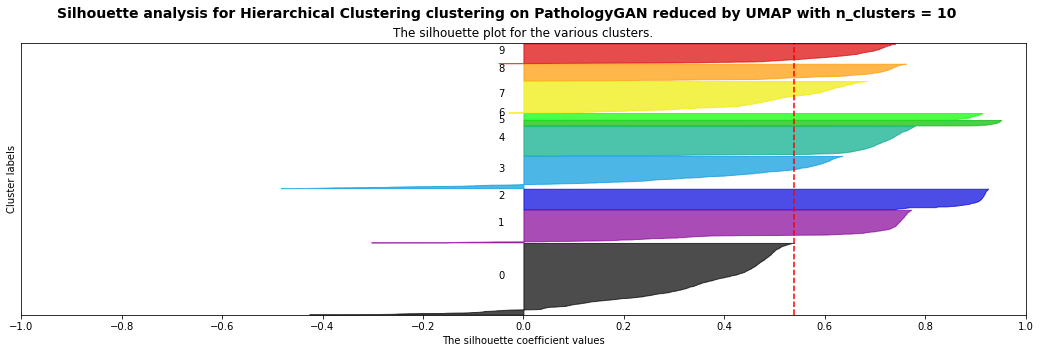

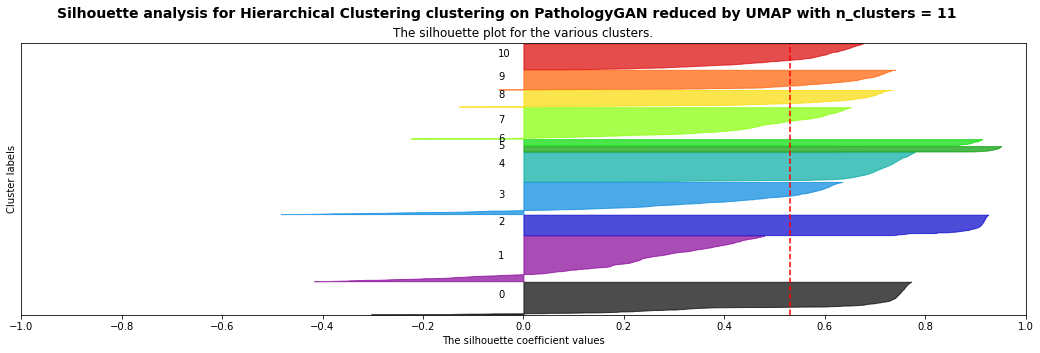

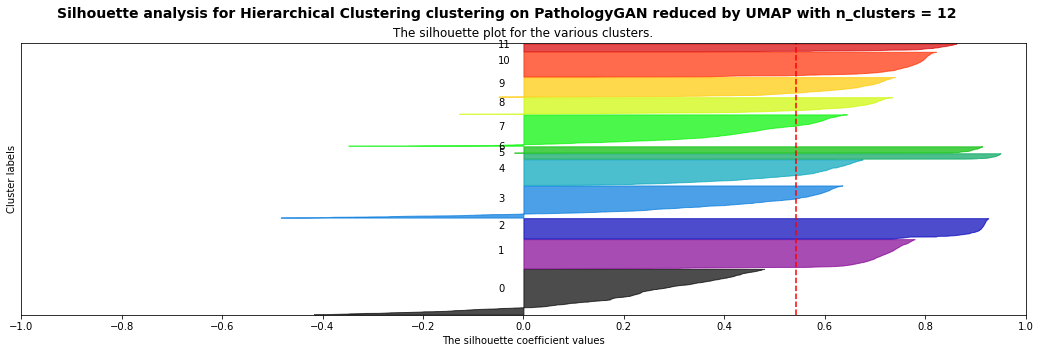

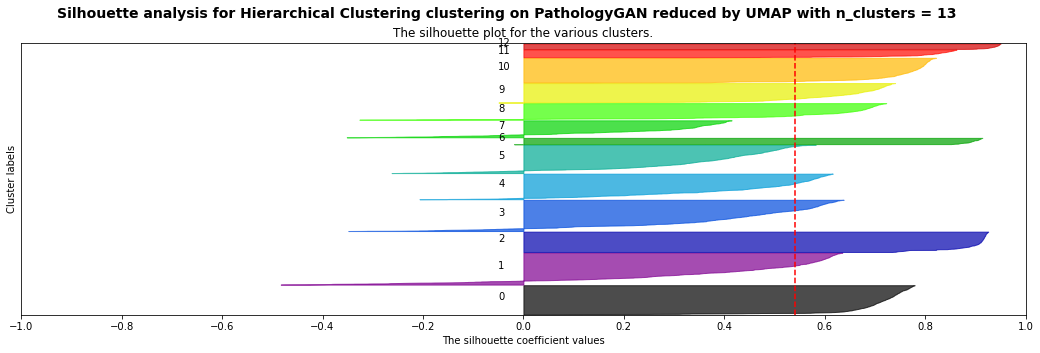

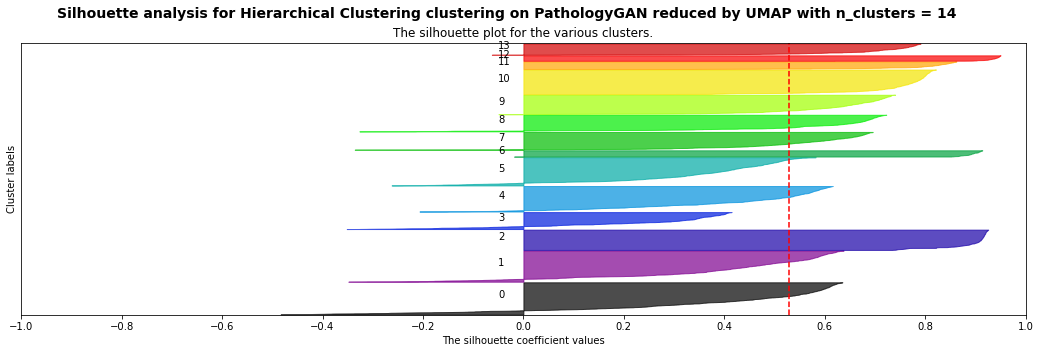

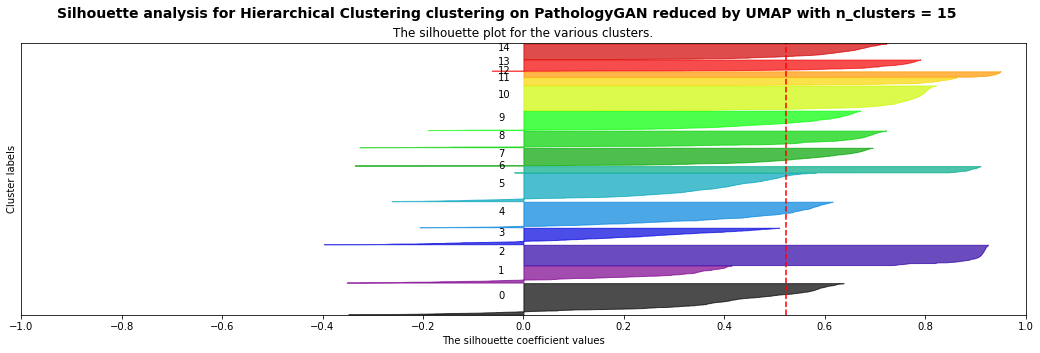

In [24]:
X = pge_umap_feature
cluster_range = range(2,16)

for n_clusters in cluster_range:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot and can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    hier_pge_umap = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean',  linkage='ward') 
    hier_pge_umap_assignment = hier_pge_umap.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, hier_pge_umap_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, hier_pge_umap_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[hier_pge_umap_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for Hierarchical Clustering clustering on PathologyGAN reduced by UMAP with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Text(0.5, 1.0, 'Dendrogram for PathologyGAN reduced by UMAP')

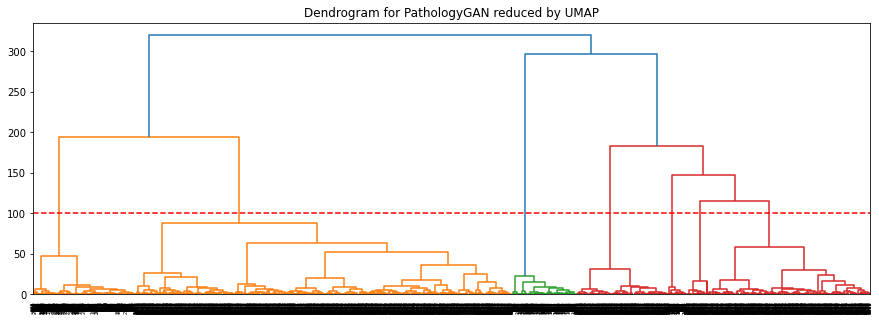

In [242]:
plt.figure(figsize=(15,5))

# Please Uncomment to run and verify dendrogram
#den = sch.dendrogram(sch.linkage(pge_umap_feature, method='ward'))

plt.axhline(y=100, color = 'red', linestyle = '--')
plt.title('Dendrogram for PathologyGAN reduced by UMAP')

Model Type 7: Hierarchical model using ResNet50 feature set reduced by PCA

For clusters = 2 avg silhouette_score = 0.12841442
For clusters = 3 avg silhouette_score = 0.13350412
For clusters = 4 avg silhouette_score = 0.15156241
For clusters = 5 avg silhouette_score = 0.13620761
For clusters = 6 avg silhouette_score = 0.12983322
For clusters = 7 avg silhouette_score = 0.13181384
For clusters = 8 avg silhouette_score = 0.1219667
For clusters = 9 avg silhouette_score = 0.12129129
For clusters = 10 avg silhouette_score = 0.115570456
For clusters = 11 avg silhouette_score = 0.115618944
For clusters = 12 avg silhouette_score = 0.111100465
For clusters = 13 avg silhouette_score = 0.1059442
For clusters = 14 avg silhouette_score = 0.10620454
For clusters = 15 avg silhouette_score = 0.09866671


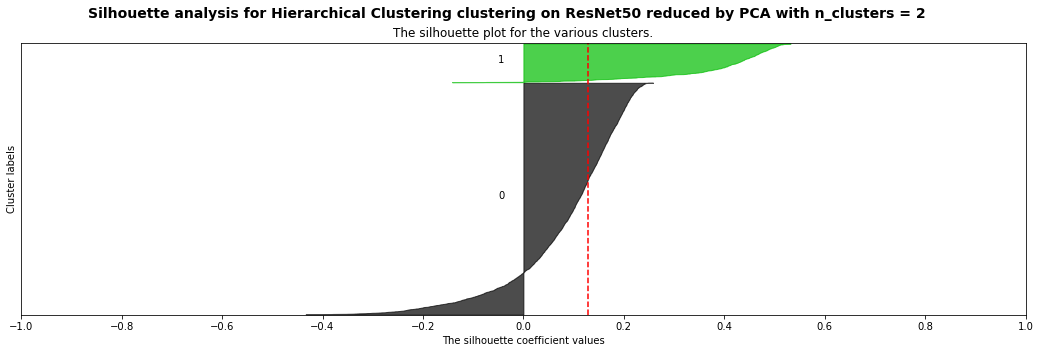

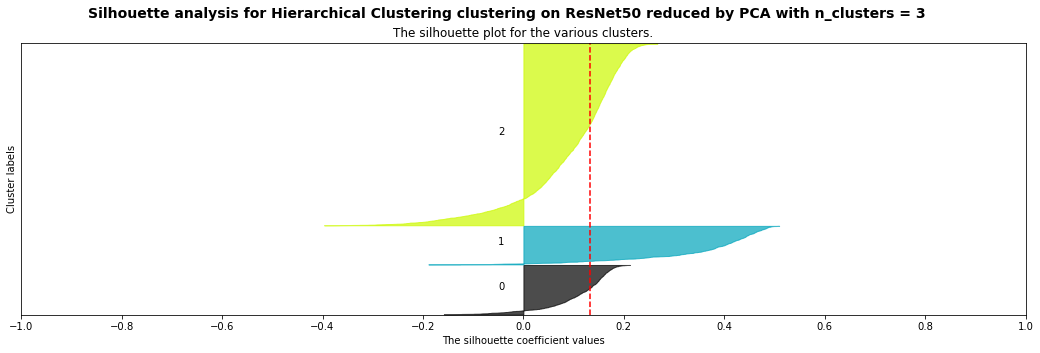

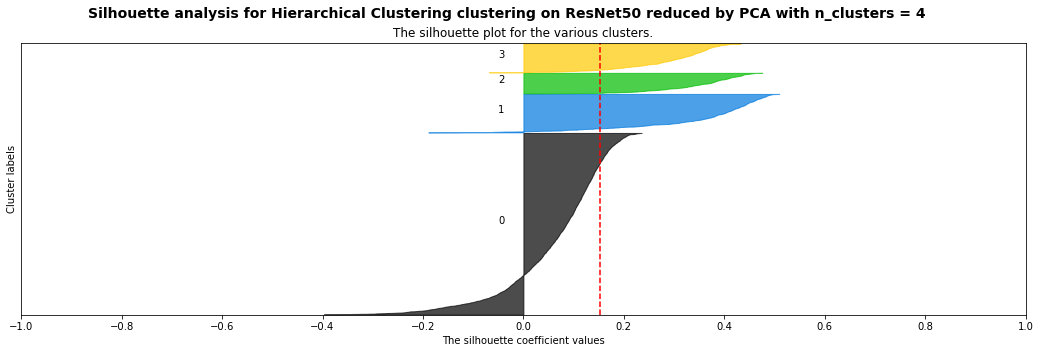

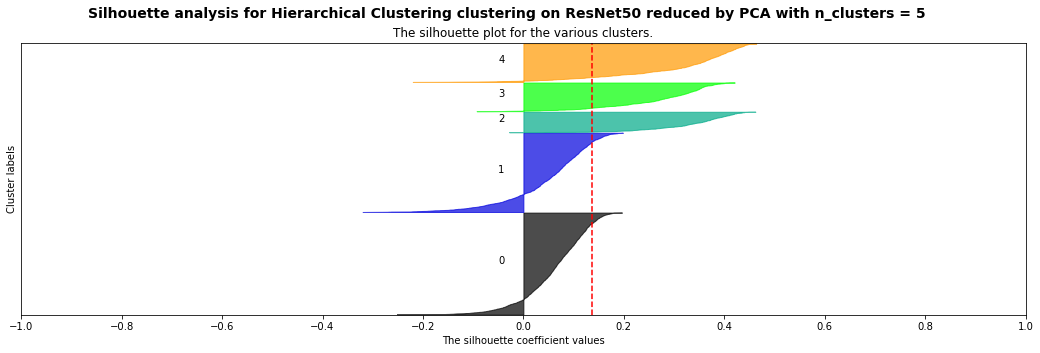

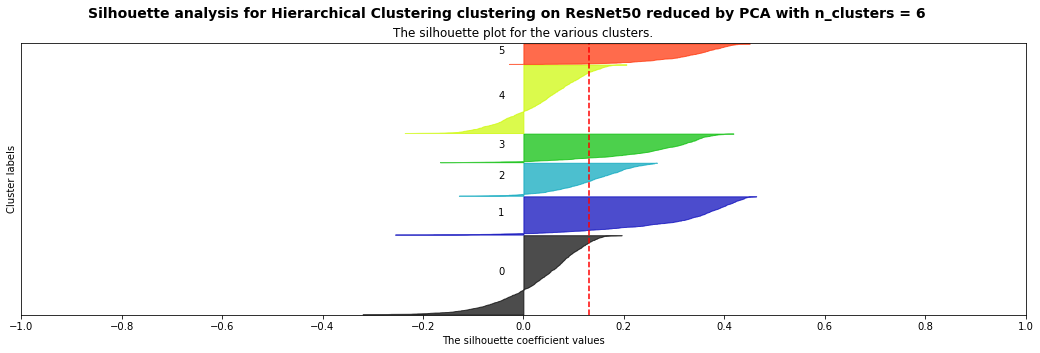

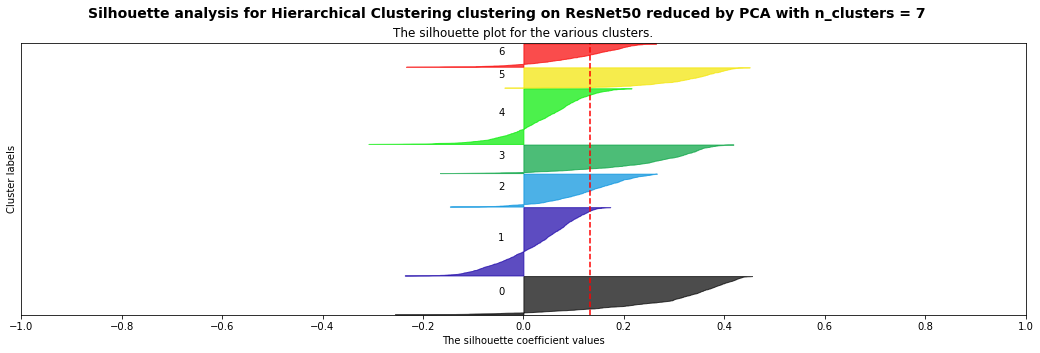

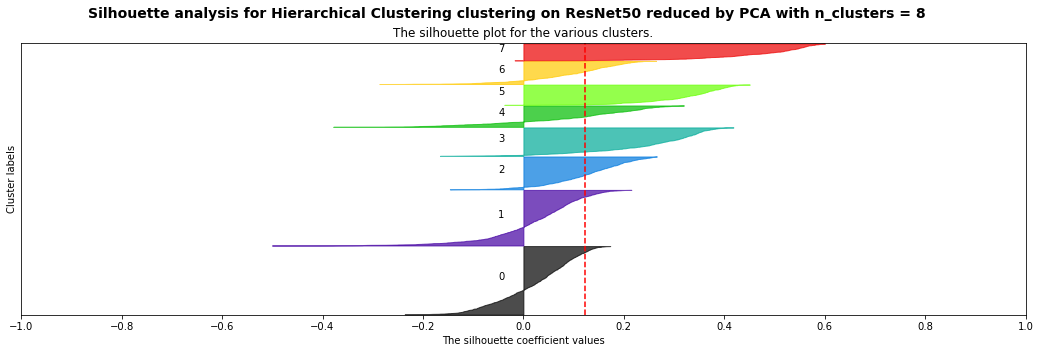

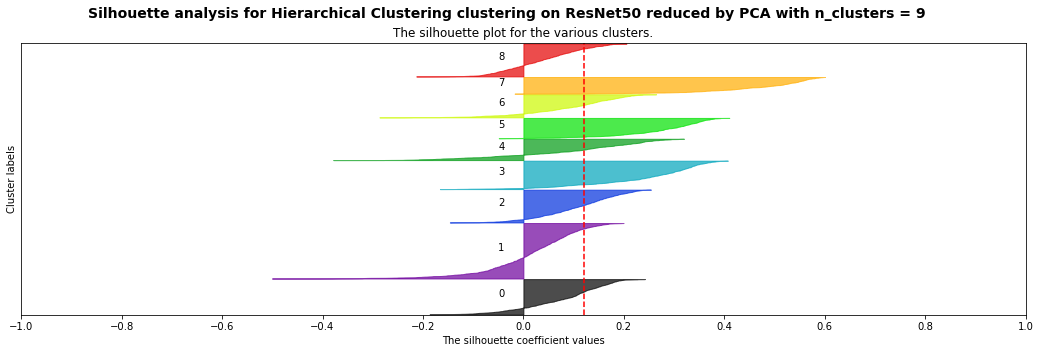

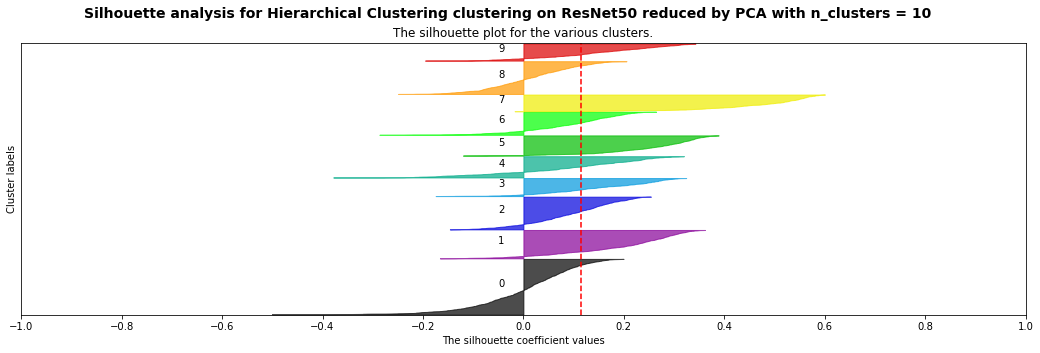

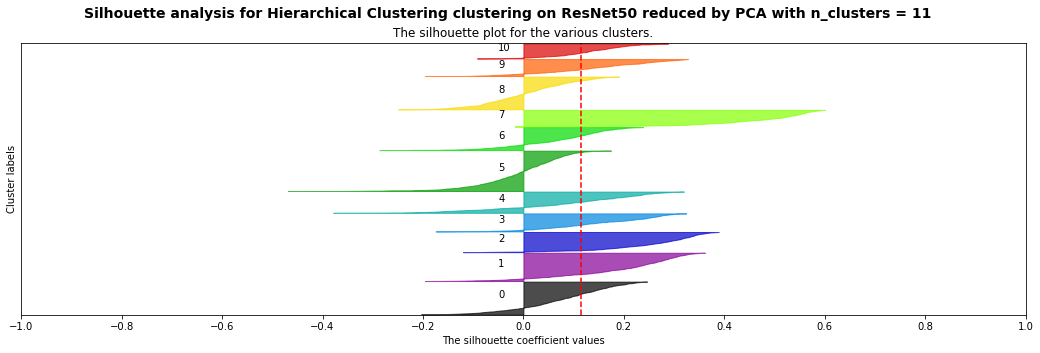

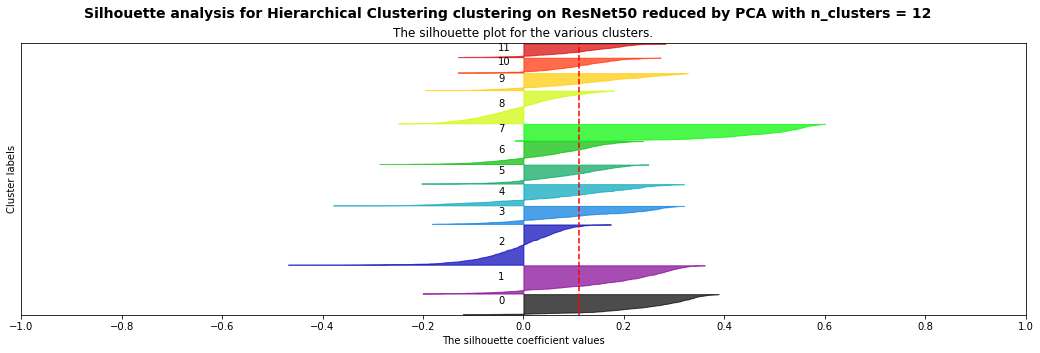

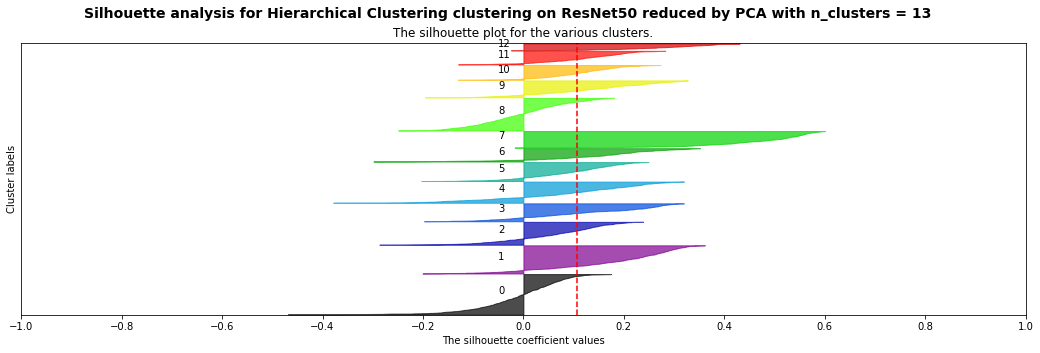

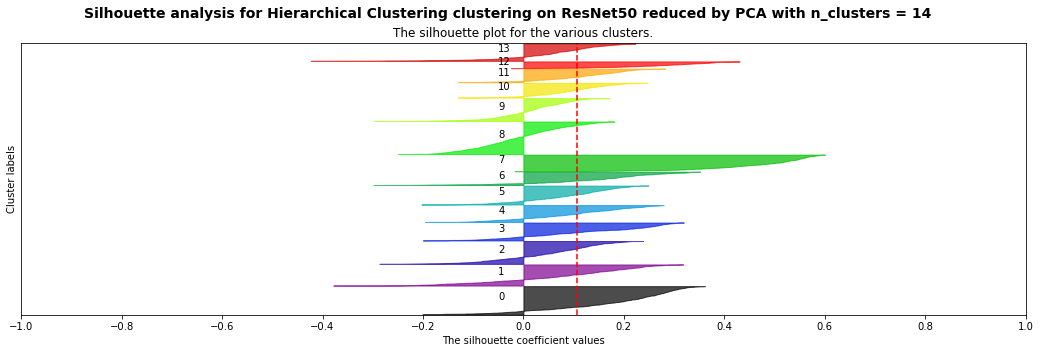

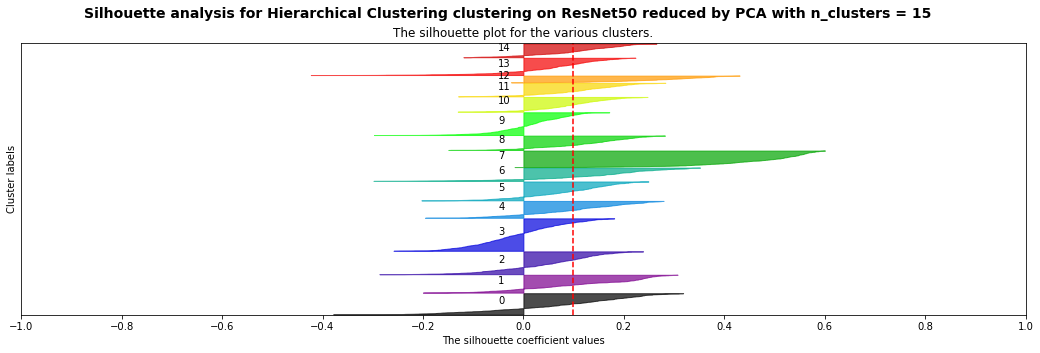

In [25]:
X = resnet50_pca_feature
cluster_range = range(2,16)

for n_clusters in cluster_range:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot and can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    hier_resnet50_pca = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean',  linkage='ward') 
    hier_resnet50_pca_assignment = hier_resnet50_pca.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, hier_resnet50_pca_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, hier_resnet50_pca_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[hier_resnet50_pca_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for Hierarchical Clustering clustering on ResNet50 reduced by PCA with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Text(0.5, 1.0, 'Dendrogram for ResNet50 reduced by PCA')

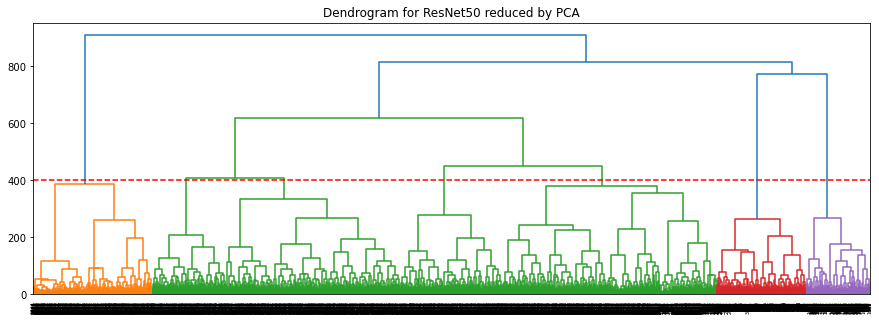

In [244]:
plt.figure(figsize=(15,5))

# Please Uncomment to run and verify dendrogram
#den = sch.dendrogram(sch.linkage(resnet50_pca_feature, method='ward'))

plt.axhline(y=400, color = 'red', linestyle = '--')
plt.title('Dendrogram for ResNet50 reduced by PCA')

Model Type 8: Hierarchical model using ResNet50 feature set reduced by UMAP

For clusters = 2 avg silhouette_score = 0.49419078
For clusters = 3 avg silhouette_score = 0.50926614
For clusters = 4 avg silhouette_score = 0.57918864
For clusters = 5 avg silhouette_score = 0.6101278
For clusters = 6 avg silhouette_score = 0.47875303
For clusters = 7 avg silhouette_score = 0.48867974
For clusters = 8 avg silhouette_score = 0.5029506
For clusters = 9 avg silhouette_score = 0.511764
For clusters = 10 avg silhouette_score = 0.51997346
For clusters = 11 avg silhouette_score = 0.5268324
For clusters = 12 avg silhouette_score = 0.54861814
For clusters = 13 avg silhouette_score = 0.554692
For clusters = 14 avg silhouette_score = 0.5473737
For clusters = 15 avg silhouette_score = 0.55679244


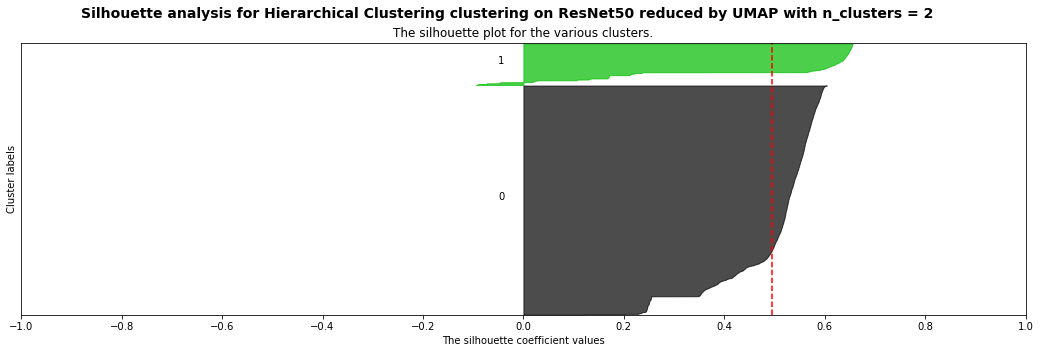

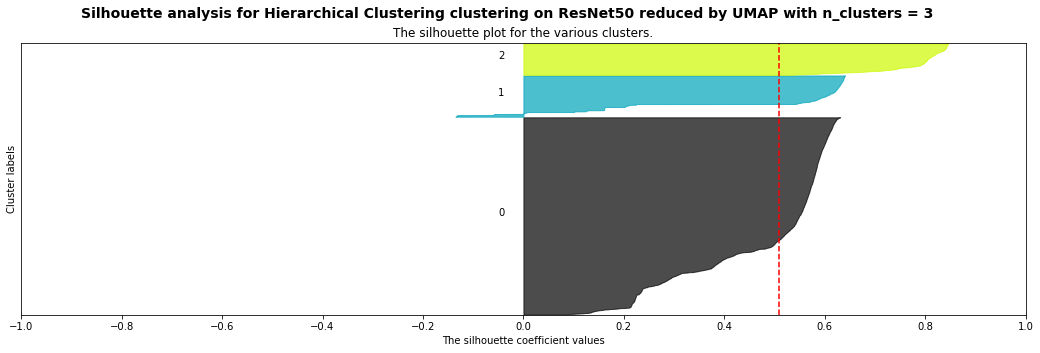

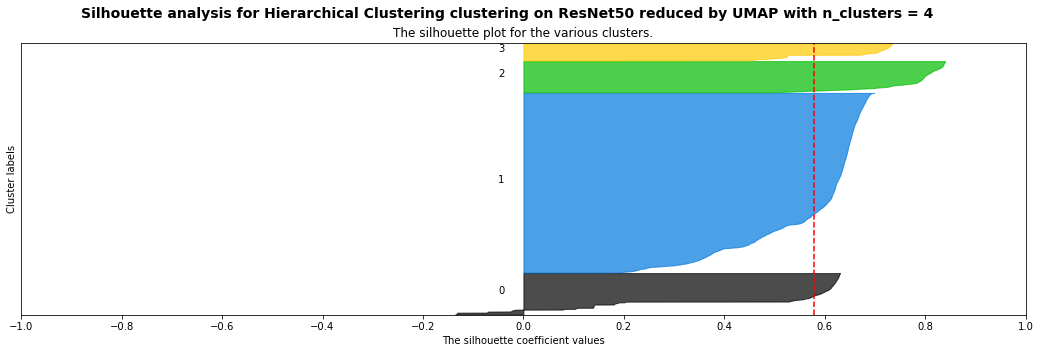

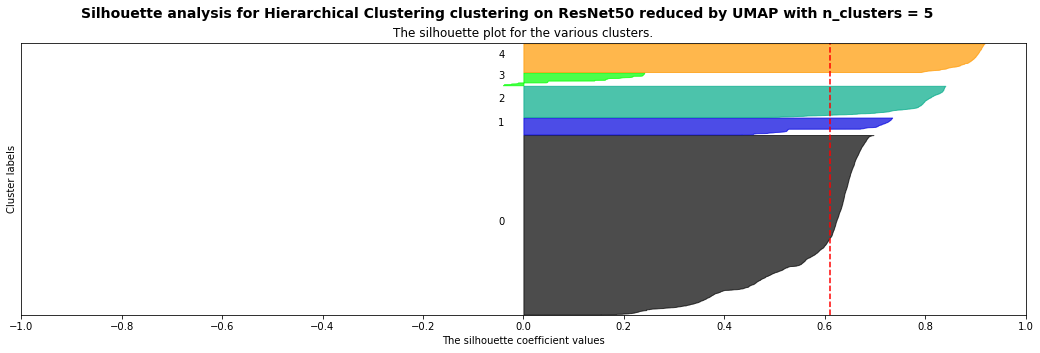

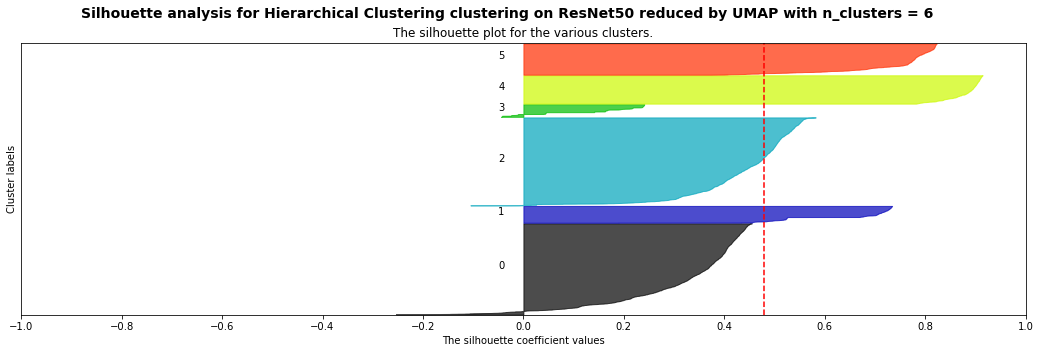

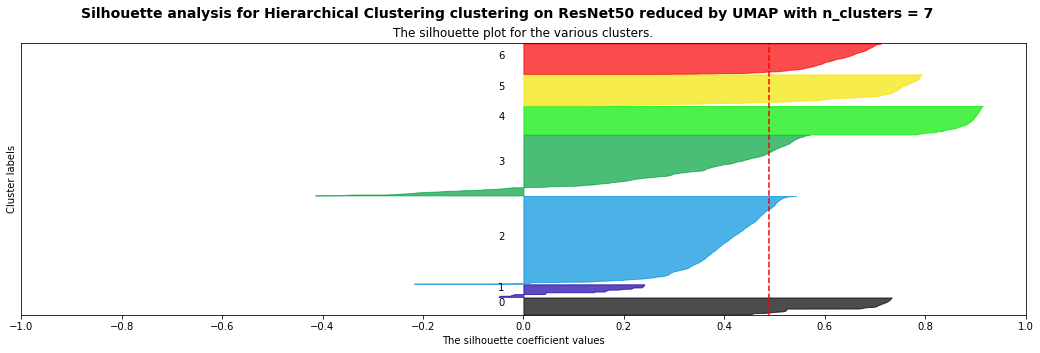

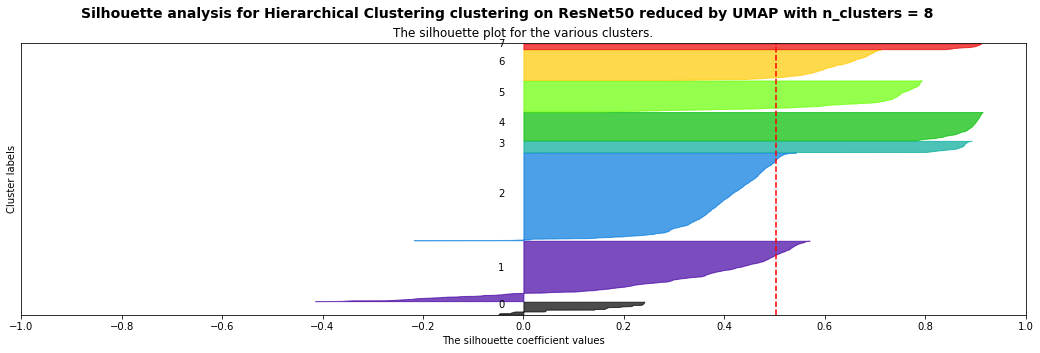

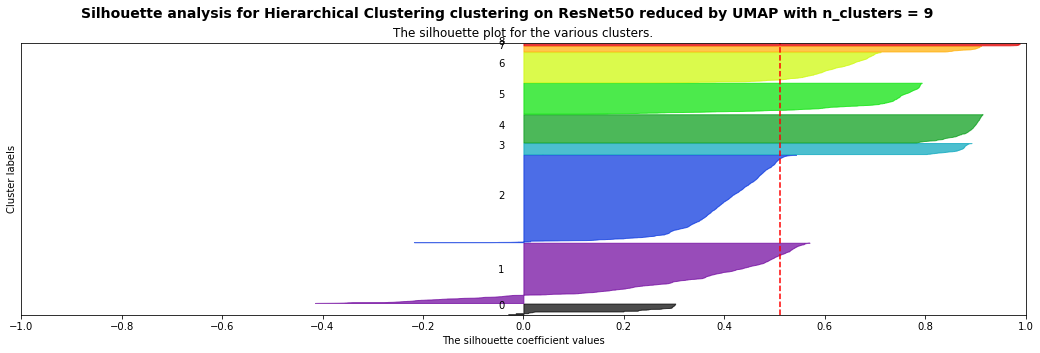

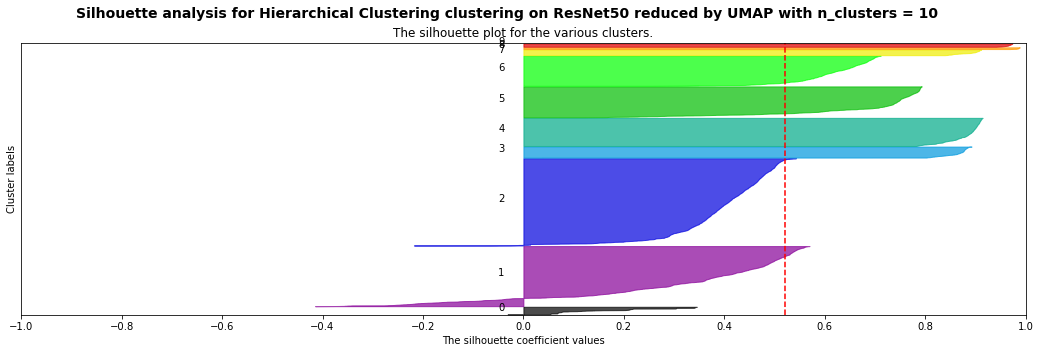

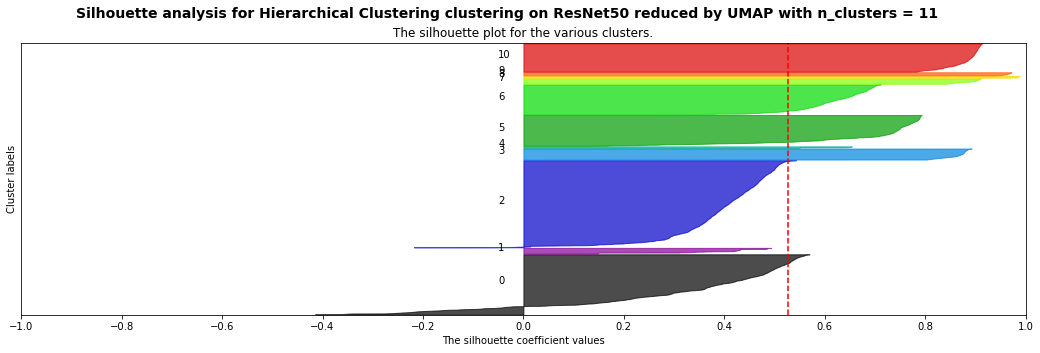

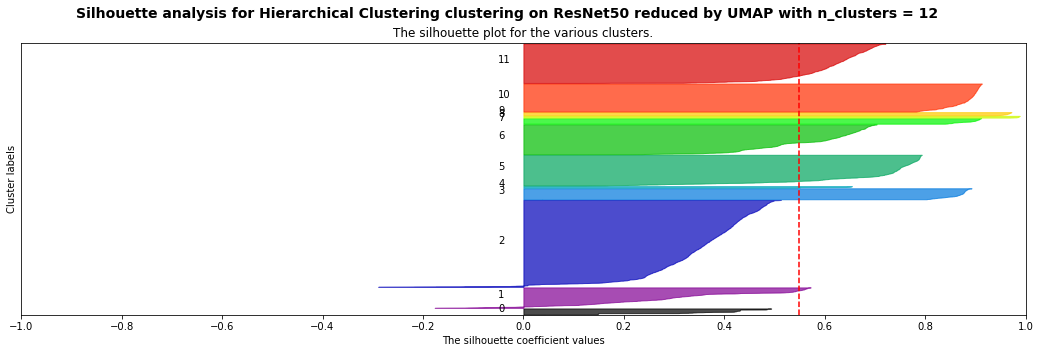

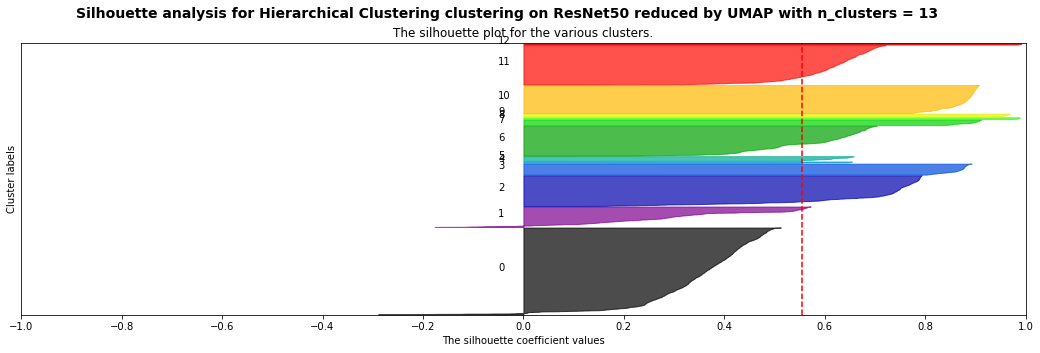

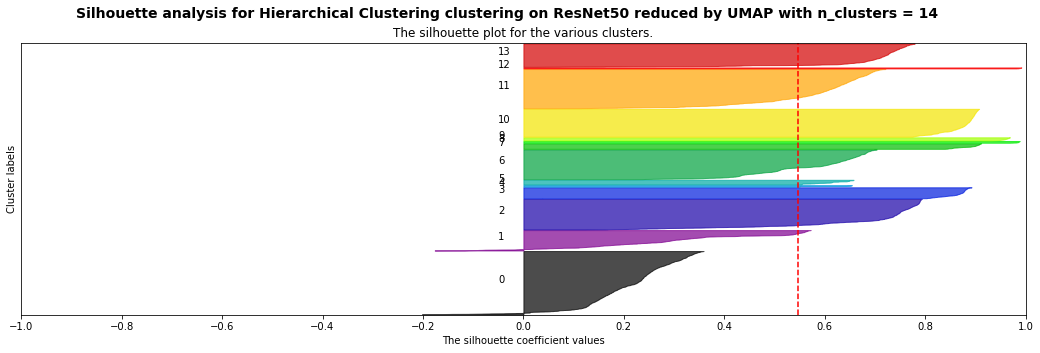

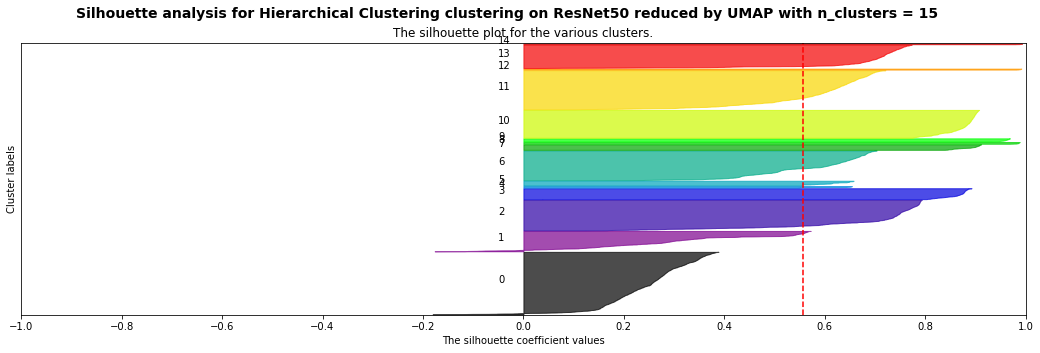

In [26]:
X = resnet50_umap_feature
cluster_range = range(2,16)

for n_clusters in cluster_range:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 5)

    # The silhouette plot and can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # to make plot readable
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    hier_resnet50_umap = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean',  linkage='ward') 
    hier_resnet50_umap_assignment = hier_resnet50_umap.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_mean = silhouette_score(X, hier_resnet50_umap_assignment)
    print( "For clusters =", n_clusters, "avg silhouette_score =", silhouette_mean)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, hier_resnet50_umap_assignment)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[hier_resnet50_umap_assignment == i]

        ith_cluster_silhouette_values.sort()

        ith_cluster_size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + ith_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_mean, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for Hierarchical Clustering clustering on ResNet50 reduced by UMAP with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Text(0.5, 1.0, 'Dendrogram for ResNet50 reduced by UMAP')

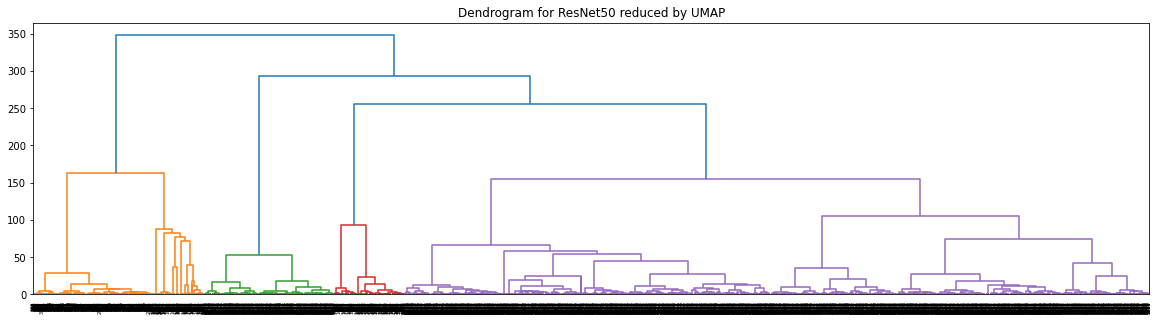

In [245]:
plt.figure(figsize=(20,5))

# Please Uncomment to run and verify dendrogram
#den = sch.dendrogram(sch.linkage(resnet50_umap_feature, method='ward'))

plt.title('Dendrogram for ResNet50 reduced by UMAP')

Based on the Average Silhouette score and the Silhouette plot the optimal number of clusters is chosen for all the 8 models -


1. K-means using PathologyGAN (reduced by PCA) clusters = 9
2. K-means using PathologyGAN (reduced by UMAP) clusters = 7
3. K-means using ResNet50 (reduced by PCA) clusters = 8
4. K-means using ResNet50 (reduced by UMAP) clusters = 9
5. Hierarchical using PathologyGAN (reduced by PCA) clusters = 9
6. Hierarchical using PathologyGAN (reduced by PCA) clusters = 7
7. Hierarchical using ResNet50 (reduced by PCA) clusters = 7
8. Hierarchical using ResNet50 (reduced by UMAP) clusters = 13


Those 8 models are trained and fitted and their predicted values are stored as below -

In [27]:
k_means_pge_pca = KMeans(n_clusters=9, random_state=10)
k_means_pge_pca_assignment = k_means_pge_pca.fit_predict(pge_pca_feature)
k_means_pge_umap = KMeans(n_clusters=7, random_state=10)
k_means_pge_umap_assignment = k_means_pge_umap.fit_predict(pge_umap_feature)
k_means_resnet50_pca = KMeans(n_clusters=8, random_state=10)
k_means_resnet50_pca_assignment = k_means_resnet50_pca.fit_predict(resnet50_pca_feature)
k_means_resnet50_umap = KMeans(n_clusters=9, random_state=10)
k_means_resnet50_umap_assignment = k_means_resnet50_umap.fit_predict(resnet50_umap_feature)

hier_pge_pca = AgglomerativeClustering(n_clusters = 9, affinity='euclidean',  linkage='ward') 
hier_pge_pca_assignment = hier_pge_pca.fit_predict(pge_pca_feature)
hier_pge_umap = AgglomerativeClustering(n_clusters = 7, affinity='euclidean',  linkage='ward') 
hier_pge_umap_assignment = hier_pge_umap.fit_predict(pge_umap_feature)
hier_resnet50_pca = AgglomerativeClustering(n_clusters = 7, affinity='euclidean',  linkage='ward') 
hier_resnet50_pca_assignment = hier_resnet50_pca.fit_predict(resnet50_pca_feature)
hier_resnet50_umap = AgglomerativeClustering(n_clusters = 13, affinity='euclidean',  linkage='ward') 
hier_resnet50_umap_assignment = hier_resnet50_umap.fit_predict(resnet50_umap_feature)

The Silhouette score and V-measure score of the 8 models having optimum number of clusters for models trained using PathologyGAN feature set

In [28]:
print("PathologyGAN")
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans PCA': [silhouette_score(pge_pca_feature, k_means_pge_pca_assignment), v_measure_score(labels, k_means_pge_pca_assignment)], 'Hierarchical PCA':[silhouette_score(pge_pca_feature, hier_pge_pca_assignment), v_measure_score(labels, hier_pge_pca_assignment)], 'Kmeans UMAP': [silhouette_score(pge_umap_feature, k_means_pge_umap_assignment), v_measure_score(labels, k_means_pge_umap_assignment)], 'Hierarchical UMAP':[silhouette_score(pge_umap_feature, hier_pge_umap_assignment), v_measure_score(labels, hier_pge_umap_assignment)]}).set_index('Metrics')



PathologyGAN


Kmeans PCA  Hierarchical PCA  Kmeans UMAP  Hierarchical UMAP
Metrics                                                                 
silhouette    0.140269          0.109597     0.615687           0.615047
V-measure     0.356276          0.375037     0.524363           0.525014

The Silhouette score and V-measure score of the selected models with optimum number of clusters for models trained using ResNet50 feature set

In [29]:
print("ResNet50")
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans PCA': [silhouette_score(resnet50_pca_feature, k_means_resnet50_pca_assignment), v_measure_score(labels, k_means_resnet50_pca_assignment)], 'Hierarchical PCA':[silhouette_score(resnet50_pca_feature, hier_resnet50_pca_assignment), v_measure_score(labels, hier_resnet50_pca_assignment)], 'Kmeans UMAP': [silhouette_score(resnet50_umap_feature, k_means_resnet50_umap_assignment), v_measure_score(labels, k_means_resnet50_umap_assignment)], 'Hierarchical UMAP':[silhouette_score(resnet50_umap_feature, hier_resnet50_umap_assignment), v_measure_score(labels, hier_resnet50_umap_assignment)]}).set_index('Metrics')


ResNet50


Kmeans PCA  Hierarchical PCA  Kmeans UMAP  Hierarchical UMAP
Metrics                                                                 
silhouette    0.159916          0.131814     0.537928           0.554692
V-measure     0.512317          0.547759     0.674390           0.689992

Visualising tissue type percentage of all the selected models with optimum number of clusters in K-means vs Hierarchical layout

In [30]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

<ipython-input-31-3869fcd3bf4c>:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



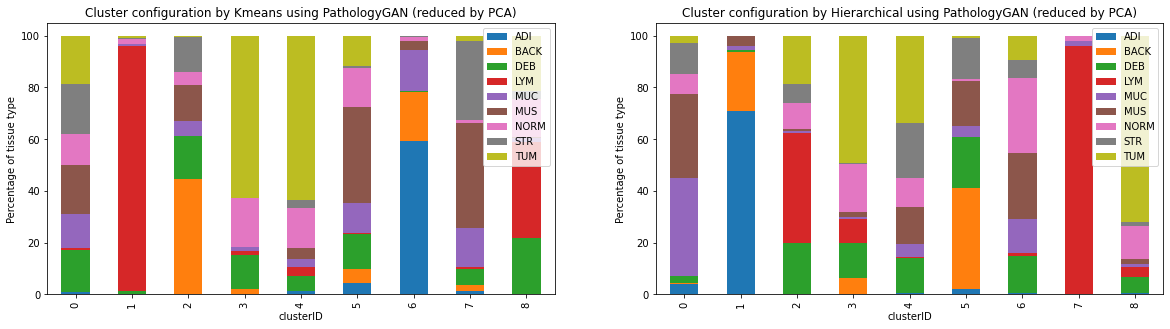

In [31]:
resulted_cluster_df = pd.DataFrame({'clusterID': k_means_pge_pca_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans using PathologyGAN (reduced by PCA)')

resulted_cluster_df = pd.DataFrame({'clusterID': hier_pge_pca_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchical using PathologyGAN (reduced by PCA)')
f.show()

<ipython-input-32-0370b13012a4>:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



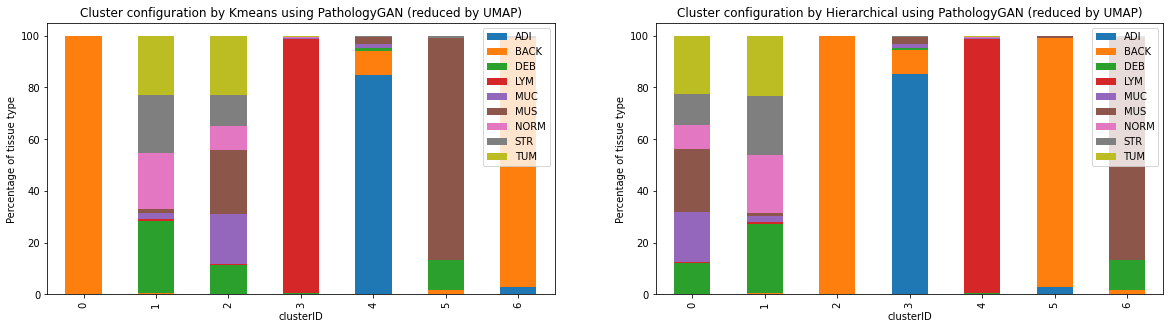

In [32]:
resulted_cluster_df = pd.DataFrame({'clusterID': k_means_pge_umap_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans using PathologyGAN (reduced by UMAP)')

resulted_cluster_df = pd.DataFrame({'clusterID': hier_pge_umap_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchical using PathologyGAN (reduced by UMAP)')
f.show()

<ipython-input-33-eb3714e1c354>:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



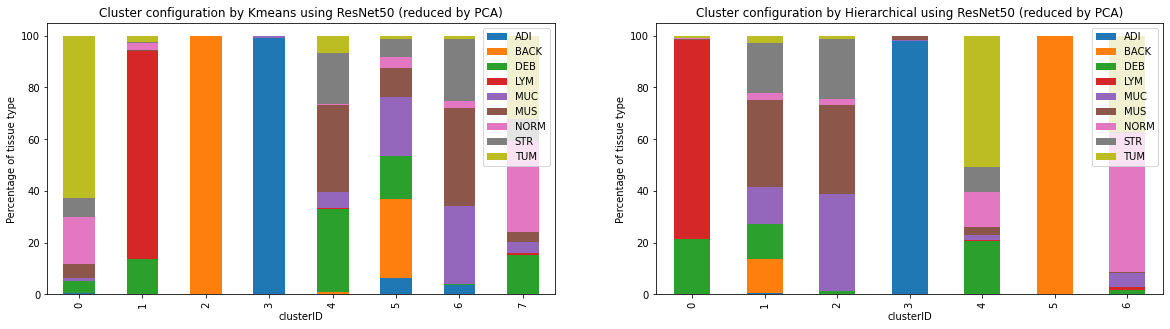

In [33]:
resulted_cluster_df = pd.DataFrame({'clusterID': k_means_resnet50_pca_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans using ResNet50 (reduced by PCA)')

resulted_cluster_df = pd.DataFrame({'clusterID': hier_resnet50_pca_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchical using ResNet50 (reduced by PCA)')
f.show()

<ipython-input-34-05f1f9b6ab9e>:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



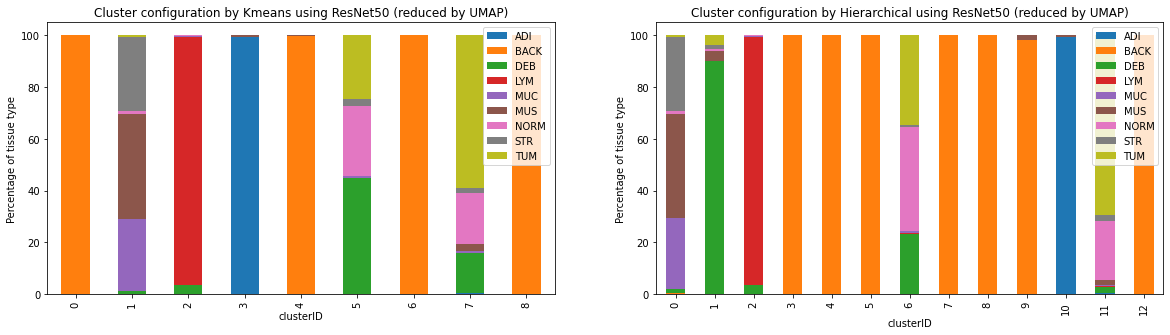

In [34]:
resulted_cluster_df = pd.DataFrame({'clusterID': k_means_resnet50_umap_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans using ResNet50 (reduced by UMAP)')

resulted_cluster_df = pd.DataFrame({'clusterID': hier_resnet50_umap_assignment, 'type': labels})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchical using ResNet50 (reduced by UMAP)')
f.show()